# Contents

**Define datatypes**
- numerical features
- categorical features


## **Feature analysis:**

[**Feature variance**](#Feature-variance)

Examine variance for continuous, numerical features
- Retrieve feature variances
- Calculate [coefficient of variation](#Coefficient-of-variation) for features


[**Feature engineering**](#Feature-engineering)


- [Misc features](#Misc-features)
    
- [Area and SF features](#Area-and-SF-features)
    - Basement area features
        - Examine TotalBsmntSF and relation to component basement area features
    - Above grade features
        - Examine GrLivArea and relation to component above grade area features
    - Examine [variance inflation factor (VIF)](#Variance-inflation-factor-(VIF)) values for reduced feature sets
        - Basement area features without TotalBsmtSF
        - Basement area features without BsmtUnfSF, BsmtFinSF1, BsmtFinSF2
        - Above grade area features without GrLivArea
        - Above grade area features without 1stFlrSF, 2ndFlrSF, LowQualFinSF
        - Reduced model (drop 4 features: 1 composite, 3 component)
        - Reduced model (drop 6 features: drop all component features)
        - Reduced model (drop 2 features: drop composite features only)

- [Porch features](#Porch-features):

Compare model performance with composite porch features and component porch features.


- [Garage features](#Garage-features):
    - Examine chi2 values to understand whether GarageCond and GarageQual are related or independent.
    - Model performance for GarageQual and GarageCond.


- [Bathroom features](#Bathroom-features)
    - see also *Ames_Base_Model2.ipynb*:
        

[**Numeric base model**](#Numeric-base-model)

*see Ames_Base_Model.ipynb* 

[**Data transformations**](#Data-transformations)

*see Ames_Data_Transformations.ipynb* and feature selection section for more notes on log transformation of SalePrice.

[**Feature selection**](#Feature-selection)

*see Ames_Data_Transformations.ipynb:* applied sequential feature selector to investigate most predictive, numerical features.


[**Categorical features**](#Categorical-features)

Add categorical features to sfs-reduced model (7 numeric features)
- sfs-reduced linear-linear model, full categorical
- sfs-reduced log-linear model, full categorical
- categorical feature evaluation
    - *7-num, 10-cat*
    - *7-num, 7-cat*

[**Resources**](#Resources)

# Summary of data cleaning:

From **Ames_Data_Cleaning.ipynb**, the following modifications were made to the Ames dataset:

**Data Types**
- OverallQual and OverallCond reclassified as ordinal datatypes (per data dictionary)
- MSSubClass reclassified as categorical (nominal) datatype
- MoSold and YrSold redefined as categorical datatypes for modeling options
- Other date features remain numeric types, to prevent dimensionality problems when ordinal encoding
- GarageYrBlt changed from 'float' to 'int', after imputation of missing values, to match other date features.


**Missing Data and Imputation**
- Numerical Features:
    - After exploring relationship between GarageYrBlt and YearBuilt, imputed missing values with YearBuilt
    - After evaluating relationship between LotArea and LotFrontage, imputed LotFrontage with median
    - Imputed remaining numerical features with median values (meadian values are the same as the mode values for discrete features)
- Categorical Features:
    - Imputed missing Electrical value with mode value
    - After evaluating Garage features, imputed missing values with 'None'
    - Imputed remaining categorical features with 'None'


**Outliers**
 - Looked at GrLivArea vs. SalePrice for ames with and without the 2 extreme GrLivArea values. I did not see any significant impact on the two models and did not consider them worth removing. **This is contrary to what De Cock suggests in his paper**

**ames_clean.pkl** include these changes.

In [3]:
# libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import statsmodels.api as sm
from statsmodels.formula.api import ols

### Import raw data, if needed for comparison.

In [5]:
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()
ames_raw.drop(columns=['index'], inplace=True)
ames_raw.head(2)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


# Import cleaned data: ames_clean.pkl

In [7]:
ames = pd.read_pickle('ames_clean.pkl')

In [8]:
ames.isnull().sum().sum()

0

In [9]:
ames.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

In [10]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   SalePrice      2580 non-null   int64  
 2   MSSubClass     2580 non-null   object 
 3   MSZoning       2580 non-null   object 
 4   LotFrontage    2580 non-null   float64
 5   LotArea        2580 non-null   int64  
 6   Street         2580 non-null   object 
 7   Alley          2580 non-null   object 
 8   LotShape       2580 non-null   object 
 9   LandContour    2580 non-null   object 
 10  Utilities      2580 non-null   object 
 11  LotConfig      2580 non-null   object 
 12  LandSlope      2580 non-null   object 
 13  Neighborhood   2580 non-null   object 
 14  Condition1     2580 non-null   object 
 15  Condition2     2580 non-null   object 
 16  BldgType       2580 non-null   object 
 17  HouseStyle     2580 non-null   object 
 18  OverallQ

In [11]:
ames.dtypes.value_counts()

object     48
int64      22
float64    10
Name: count, dtype: int64

## Define datatypes

### Numerical features

In [14]:
ames.select_dtypes(include=['float64', 'int64'])

,GrLivArea,SalePrice,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,126000,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,139500,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,...,1984,1.0,266.0,0,105,0,0,0,0,0
2,1001,124900,60.0,6060,1930,2007,0.0,737.0,0.0,100.0,...,1930,1.0,216.0,154,0,42,86,0,0,0
3,1039,114000,80.0,8146,1900,2003,0.0,0.0,0.0,405.0,...,1940,1.0,281.0,0,0,168,0,111,0,0
4,1665,227000,70.0,8400,2001,2001,0.0,643.0,0.0,167.0,...,2001,2.0,528.0,0,45,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,952,121000,68.0,8854,1916,1950,0.0,0.0,0.0,952.0,...,1916,1.0,192.0,0,98,0,0,40,0,0
2576,1733,139600,68.0,13680,1955,1955,0.0,0.0,0.0,0.0,...,1955,2.0,452.0,0,0,0,0,0,0,0
2577,2002,145000,82.0,6270,1949,1950,0.0,284.0,0.0,717.0,...,1949,3.0,871.0,0,0,0,0,0,0,0
2578,1842,217500,68.0,8826,2000,2000,144.0,841.0,0.0,144.0,...,2000,2.0,486.0,193,96,0,0,0,0,0


In [15]:
ames.select_dtypes(include=['float64', 'int64']).columns

Index(['GrLivArea', 'SalePrice', 'LotFrontage', 'LotArea', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

**Note:** These are the correct, 32 numerical features

In [17]:
# Define numerical features without target SalePrice
numerical_features_list = ames.select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_features_list.remove('SalePrice')
print(f'number of numerical features (without target): {len(numerical_features_list)}')
numerical_features = ames[numerical_features_list]
numerical_features.head(2)

number of numerical features (without target): 31


,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


### Define categorical features

In [19]:
print(f'number of categorical features: { len(ames.select_dtypes(include=["object"]).columns) }')

number of categorical features: 48


In [20]:
ames.select_dtypes(include=["object"]).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [21]:
# Define nominal features from Ames_Data_Cleaning.ipynb analysis
nominal_features_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                        'MiscFeature', 'SaleType', 'SaleCondition']

print(f'number of nominal features: {len(nominal_features_list)}')
nominal_features = ames[nominal_features_list]
nominal_features.head(2)

number of nominal features: 23


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,30,RL,Pave,None,Lvl,Corner,SWISU,Norm,Norm,1Fam,...,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,None,WD,Normal
1,120,RL,Pave,None,Lvl,Inside,Edwards,Norm,Norm,TwnhsE,...,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,Attchd,None,WD,Normal


In [22]:
# Define ordinal features from Ames_Data_Cleaning.ipynb analysis
ordinal_features_list = ['Electrical', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
                        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MoSold', 'YrSold']
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


# Feature variance
[Contents](#Contents)

Look at the variances for the continuous, numerical features 

In [24]:
continuous_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
                        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                        'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 
                        'SalePrice']

In [25]:
variance_features = ames[continuous_features].copy()
variance_features.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

In [26]:
# drop SalePrice (only look at independent feature variances)
variance_features.drop(columns=['SalePrice'], inplace=True)
variance_features.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [27]:
variance_features.head(2)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,68.0,7890,0.0,238.0,0.0,618.0,856.0,856,0,0,856,399.0,0,0,0,0,166,0,0
1,42.0,4235,149.0,552.0,393.0,104.0,1049.0,1049,0,0,1049,266.0,0,105,0,0,0,0,0


In [28]:
from sklearn.feature_selection import VarianceThreshold

In [29]:
# scaler = StandardScaler()
# scaled_df = pd.DataFrame(scaler.fit_transform(variance_features), columns=variance_features.columns)

In [30]:
# scaled_df

VarianceThreshold's default threshold = 0.0

In [32]:
variance_selector = VarianceThreshold()

In [33]:
variance_selector.fit(variance_features)

VarianceThreshold()

In [34]:
variances = variance_selector.variances_
variances

array([   292., 213945.,   1600.,   2288.,   1526.,   2336.,   3206.,
         3486.,   1872.,   1064.,   4342.,   1488.,   1424.,    742.,
         1012.,    508.,    576.,    800.,  15500.])

In [35]:
import pandas as pd
variances_df = pd.DataFrame({
    'feature': variance_features.columns,
    'variance': variances
}).sort_values('variance', ascending=False)

print(variances_df)

          feature  variance
1         LotArea  213945.0
18        MiscVal   15500.0
10      GrLivArea    4342.0
7        1stFlrSF    3486.0
6     TotalBsmtSF    3206.0
5       BsmtUnfSF    2336.0
3      BsmtFinSF1    2288.0
8        2ndFlrSF    1872.0
2      MasVnrArea    1600.0
4      BsmtFinSF2    1526.0
11     GarageArea    1488.0
12     WoodDeckSF    1424.0
9    LowQualFinSF    1064.0
14  EnclosedPorch    1012.0
17       PoolArea     800.0
13    OpenPorchSF     742.0
16    ScreenPorch     576.0
15      3SsnPorch     508.0
0     LotFrontage     292.0


### Coefficient of variation

The Coefficient of Variation (CV), or relative standard deviation, is a standardized measure of dispersion of a frequency distribution. It is defined as the ratio of the standard deviation to the mean, expressed as a percentage. 

$$CV = \sigma / \mu * 100$$

The CV allows for the comparison of variability between features with different units or different means.

Looking at CV values can provide insights into:
- Scale Sensitivity: Features with high CV might dominate unscaled models
- Feature Stability: Low CV features are more consistent and reliable
- Transformation Needs: Very high CV suggests potential for log/sqrt transformation
- Multicollinearity Context: Compare CV within multicollinear groups to understand which has more meaningful variation

In [38]:
# include mean and CV 
variance_features = pd.DataFrame({
    'feature': variances_df['feature'],
    'variance': variances_df['variance'],
    'mean': [variance_features[col].mean() for col in variances_df['feature']],
    'std': [variance_features[col].std() for col in variances_df['feature']],
})

# calculate cv
variance_features['cv'] = 100 * variance_features['std'] / variance_features['mean'].abs()
variance_features = variance_features.sort_values('variance', ascending=False)

print(variance_features[['feature', 'variance', 'mean', 'cv']])

          feature  variance          mean           cv
1         LotArea  213945.0  10120.153488    80.304492
18        MiscVal   15500.0     48.731395  1023.416330
10      GrLivArea    4342.0   1486.039922    32.882709
7        1stFlrSF    3486.0   1144.975194    32.835555
6     TotalBsmtSF    3206.0   1036.664341    40.367531
5       BsmtUnfSF    2336.0    539.066279    78.862469
3      BsmtFinSF1    2288.0    444.322868    96.608432
8        2ndFlrSF    1872.0    336.820155   125.904714
2      MasVnrArea    1600.0     98.769380   177.733267
4      BsmtFinSF2    1526.0     53.218217   327.694651
11     GarageArea    1488.0    466.845349    44.433700
12     WoodDeckSF    1424.0     95.919767   134.541627
9    LowQualFinSF    1064.0      4.244574  1046.126348
14  EnclosedPorch    1012.0     23.214341   276.156128
17       PoolArea     800.0      1.662016  1825.458087
13    OpenPorchSF     742.0     46.085271   143.344418
16    ScreenPorch     576.0     16.200388   350.761875
15      3S

High CV values indicate more variable features. 

Low CV values indicate more stable features.

MiscVal, LowQualFinSF, PoolArea, 3SsnPorch are all very high, indicating a lot of variability, sparsity, and zero values.

In [40]:
print(ames['MiscVal'].value_counts()[0])
print(ames['LowQualFinSF'].value_counts()[0])
print(ames['PoolArea'].value_counts()[0])
print(ames['3SsnPorch'].value_counts()[0])
print(f'len ames: {len(ames)}')

2485
2547
2571
2550
len ames: 2580


In [41]:
print(ames['ScreenPorch'].value_counts()[0])
print(ames['EnclosedPorch'].value_counts()[0])
print(ames['WoodDeckSF'].value_counts()[0])
print(ames['OpenPorchSF'].value_counts()[0])
print(ames['BsmtFinSF2'].value_counts()[0])
print(ames['MiscFeature'].value_counts()[0])

2354
2170
1335
1170
2249
2483


/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_80556/261606669.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(ames['MiscFeature'].value_counts()[0])


In [42]:
len(ames)

2580

**Variance Summary:**

According to the cv values
- **MiscFeature** and **MiscVal** are not useful. Most of the observations are 'None' observations. Suggest dropping them, after further investigation.
- **LowQualFinSF**, **PoolArea**, **3SsnPorch** have very high variances (due to a high percentage of zero values). Suggest dropping as well but only after further investigation.

# Feature engineering

[Contents](#Contents)

Consider some of the following feature groups for feature engineering and feature reduction

- Misc features
- Area and SF features
- Porch features
- GarageCond and GarageQual features
- Bathroom features
- Basement features
- ExterQual and ExterCond features
- OverallCond and OverallQual features

- Condition1 and Condition2 features

# Misc features
[Contents](#Contents)

In [46]:
ames['MiscFeature'].value_counts()

MiscFeature
None    2483
Shed      88
Gar2       5
Othr       3
TenC       1
Name: count, dtype: int64

In [47]:
print(f"Number of MiscVal = 0: {ames['MiscVal'].value_counts()[0]}")

Number of MiscVal = 0: 2485


In [48]:
print(f"Number of MiscVal != 0: {ames['MiscVal'].value_counts()[1:].sum()}")

Number of MiscVal != 0: 95


In [49]:
misc_features = ames[['MiscFeature', 'MiscVal']]
misc_features

,MiscFeature,MiscVal
0,None,0
1,None,0
2,None,0
3,None,0
4,None,0
...,...,...
2575,None,0
2576,None,0
2577,None,0
2578,None,0


In [50]:
misc_features.groupby(by=['MiscFeature']).value_counts()

MiscFeature  MiscVal
Gar2         3000          1
             4500          1
             8300          1
             12500         1
             15500         1
None         0          2483
Othr         0             1
             3500          1
             6500          1
Shed         400          17
             500          13
             450           8
             600           8
             700           7
             2000          6
             1200          3
             1500          3
             480           2
             650           2
             2500          2
             0             1
             80            1
             300           1
             350           1
             420           1
             455           1
             490           1
             560           1
             750           1
             800           1
             900           1
             1000          1
             1150          1
             1300     

In [51]:
misc_features[misc_features['MiscFeature']!='None']

,MiscFeature,MiscVal
19,Shed,700
28,Shed,350
42,Othr,6500
50,Shed,1512
105,Gar2,15500
...,...,...
2478,Shed,800
2482,Shed,500
2495,Shed,400
2505,Gar2,4500


In [52]:
ames[ames['MiscFeature']=='Gar2']

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
105,958,151500,20,RL,68.0,12772,Pave,None,IR1,Lvl,...,0,0,None,None,Gar2,15500,4,2007,WD,Normal
191,930,99000,20,RL,68.0,9520,Pave,None,Reg,Bnk,...,0,0,None,MnPrv,Gar2,3000,5,2008,WD,Normal
1526,1329,172000,20,RL,81.0,14267,Pave,None,IR1,Lvl,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2106,2620,190000,90,RL,68.0,18890,Pave,None,IR1,Lvl,...,0,0,None,None,Gar2,8300,8,2007,WD,Normal
2505,960,125000,20,RM,65.0,9750,Pave,Grvl,Reg,Lvl,...,0,0,None,None,Gar2,4500,7,2006,WD,Normal


In [53]:
ames['SalePrice'].describe()

count      2580.000000
mean     178059.623256
std       75031.089374
min       12789.000000
25%      129975.000000
50%      159900.000000
75%      209625.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [54]:
ames['SalePrice'].agg(func=['sum', 'mean', 'min', 'max'], axis=0)

sum     4.593938e+08
mean    1.780596e+05
min     1.278900e+04
max     7.550000e+05
Name: SalePrice, dtype: float64

- **MiscFeature** and **MiscVal:** Most of the MiscFeature observations are 'None' observations. 88 rows are sheds, with 5 properties having 2nd garages of significant value. No elevators. One tennis court. They cover too many unrelated categories that are hard to compare and understand between properties. Suggest dropping them.

# Area and SF features
[Contents](#Contents)

### Basement SF features

[Contents](#Contents)

What are Type 1 and Type 2 BsmtFinSF features? 

**BsmtFin SF 1** (Continuous): Type 1 finished square feet

**BsmtFin SF 2** (Continuous): Type 2 finished square feet

**BsmtFin Type 1** (Ordinal) AND **BsmtFinType 2** (Ordinal): 
    Rating of basement finished area (if multiple types)

- GLQ	Good Living Quarters
- ALQ	Average Living Quarters
- BLQ	Below Average Living Quarters	
- Rec	Average Rec Room
- LwQ	Low Quality
- Unf	Unfinshed
- NA	No Basement


'Finished' Basement (BsmtFinSF1 and BsmtFinSF2 can refer to different kinds of space and may not be living space).
So, TotalBsmtSF can also mean a variety of space, not all comparable to the house living area.

In [58]:
bsmt_sf_features = ames[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]
bsmt_sf_features

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,238.0,0.0,618.0,856.0
1,552.0,393.0,104.0,1049.0
2,737.0,0.0,100.0,837.0
3,0.0,0.0,405.0,405.0
4,643.0,0.0,167.0,810.0
...,...,...,...,...
2575,0.0,0.0,952.0,952.0
2576,0.0,0.0,0.0,0.0
2577,284.0,0.0,717.0,1001.0
2578,841.0,0.0,144.0,985.0


In [59]:
bsmt_sf_features = bsmt_sf_features.copy()

bsmt_sf_features['sum_features'] = (
    bsmt_sf_features['BsmtFinSF1'] + 
    bsmt_sf_features['BsmtFinSF2'] + 
    bsmt_sf_features['BsmtUnfSF']
)
bsmt_sf_features

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,sum_features
0,238.0,0.0,618.0,856.0,856.0
1,552.0,393.0,104.0,1049.0,1049.0
2,737.0,0.0,100.0,837.0,837.0
3,0.0,0.0,405.0,405.0,405.0
4,643.0,0.0,167.0,810.0,810.0
...,...,...,...,...,...
2575,0.0,0.0,952.0,952.0,952.0
2576,0.0,0.0,0.0,0.0,0.0
2577,284.0,0.0,717.0,1001.0,1001.0
2578,841.0,0.0,144.0,985.0,985.0


In [60]:
# check to see if TotalBsmtSF is always the sum of the component features
bsmt_sf_features['TotalBsmtSF'].equals(bsmt_sf_features['sum_features'])

False

In [61]:
# extract the rows that are not the same
different_rows = bsmt_sf_features.query('TotalBsmtSF != sum_features')

In [62]:
different_rows

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,sum_features
912,384.0,0.0,448.0,979.0,832.0


In [63]:
ames_raw[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']].iloc[912]

BsmtFinSF1    NaN
BsmtFinSF2    NaN
BsmtUnfSF     NaN
TotalBsmtSF   NaN
Name: 912, dtype: float64

In [64]:
ames_raw[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']].isnull().sum().sum()

4

**Note:** For this one observation, it looks like all basement area features were imputed with medians and their sum does not align. It would be best practice to impute the BsmtFinSF1 and BsmtFinSF2 with median values, and then impute TotalBsmtSF with their sum for this row. But the difference is not significant, and the disparity could serve as a flag that this data is not original for this particular house.  

$$TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF$$

In [67]:
bsmt_corr_matrix = ames[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']].corr()
print(bsmt_corr_matrix)

             BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF
BsmtFinSF1     1.000000   -0.058894  -0.480910     0.512646
BsmtFinSF2    -0.058894    1.000000  -0.242302     0.110133
BsmtUnfSF     -0.480910   -0.242302   1.000000     0.421579
TotalBsmtSF    0.512646    0.110133   0.421579     1.000000


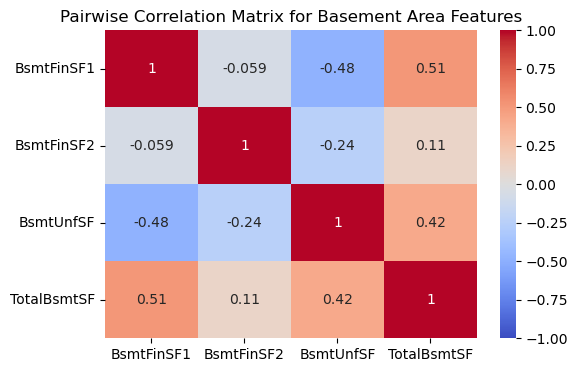

In [68]:
# visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(bsmt_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlation Matrix for Basement Area Features')
plt.show()

In [69]:
len(ames)

2580

In [70]:
print(len(ames[ames['BsmtFinSF1'] == 0.0]))
print(len(ames[ames['BsmtFinSF2'] == 0.0]))
print(len(ames[ames['BsmtUnfSF'] == 0.0]))

774
2249
216


BsmtFinSF2 may not be highly correlated with TotalBsmtSF simply because most values are 0.

### Above grade area features

[Contents](#Contents)

**Gr Liv Area** (Continuous): Above grade (ground) living area square feet

**1st Flr SF** (Continuous): First Floor square feet
 
**2nd Flr SF** (Continuous)	: Second floor square feet

**Low Qual Fin SF** (Continuous): Low quality finished square feet (all floors)

**Note:** While the data dictionary defines LowQualFinSF as applying to all floors, the analysis below shows that it is part of the above grade square footage, not the basement square footage.

In [73]:
above_grade_features = ames[['GrLivArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']]
above_grade_features

,GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF
0,856,856,0,0
1,1049,1049,0,0
2,1001,1001,0,0
3,1039,717,322,0
4,1665,810,855,0
...,...,...,...,...
2575,952,952,0,0
2576,1733,1733,0,0
2577,2002,1001,1001,0
2578,1842,985,857,0


In [74]:
above_grade_features = above_grade_features.copy()

above_grade_features['sum_features'] = (
    above_grade_features['1stFlrSF'] + 
    above_grade_features['2ndFlrSF'] +
    above_grade_features['LowQualFinSF']
)
above_grade_features

,GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF,sum_features
0,856,856,0,0,856
1,1049,1049,0,0,1049
2,1001,1001,0,0,1001
3,1039,717,322,0,1039
4,1665,810,855,0,1665
...,...,...,...,...,...
2575,952,952,0,0,952
2576,1733,1733,0,0,1733
2577,2002,1001,1001,0,2002
2578,1842,985,857,0,1842


In [75]:
above_grade_features['GrLivArea'].equals(above_grade_features['sum_features'])

True

There is perfect collinearity within these features as well:

$$GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualSF$$

### Variance inflation factor (VIF)

Examine VIF for multicollinear features. Used to detect multicollinearity and quantify "how much variance of a regression coefficient is inflated due to corrleations among predictors." - Vikash Singh

$$VIF(X) = 1 - R^2$$

where R2 is the coeff of determination for feature X regressed on all other predictors.

- **VIF = 1: no multicollinearity.** "The predictor is not correlated with other predictors, so it doesn’t inflate the standard error or affect the model’s stability."

- **VIF between 1 and 5: moderate multicollinearity.** "There’s some correlation with other predictors, but it’s usually not severe. However, it’s worth keeping an eye on these predictors to see if multicollinearity becomes a problem, especially if other VIF values are high."

- **VIF > 5: high multicollinearity.** "The predictor’s standard error may be noticeably inflated, which can make its coefficient less reliable. Consider taking steps to reduce multicollinearity, like removing or combining correlated predictors."

- **VIF > 10: serious multicollinearity.** "The predictor’s standard error is highly inflated, and its coefficient estimate is likely unstable. Corrective actions, such as removing the predictor or using regularization techniques, are usually needed."

"...if a predictor’s VIF is 10, it indicates that the variance of that predictor’s coefficient is 10 times what it would be if there were no multicollinearity." 

**Notes:**
"It is not uncommon for statisticians to drop features with vif>5" (as well as features with vif>10).

*From Vinod: note that GarageArea and GarageCars have vif>5...* 

VIF analysis is useful for MLR models. VIF values help identify which features are highly multicollinear and must be handled for the MLR model. Ridge and Lasso do this evaluation under the hood and reduce (or exclude) those highly multicollinear features automatically. That is, Ridge and Lasso can handle multicollinearity well whereas MLR cannot.

We expect that the features with high VIF values above would be similar to the features reduced (zeroed) by Ridge and Lasso. 

**Note:** 

One reference I found adds a constant column to the dataset before calculate VIF.
The other does not. ?

**Always add a constant when using statsmodels to calculate VIF.**

In [80]:
# get numerical features data for calculating VIF, dropping target feature, SalePrice
numerical_features_df = ames.select_dtypes(include=['float64', 'int64'])
numerical_features_df.drop(columns=['SalePrice'], axis=1, inplace=True)
numerical_features_df.head(2)

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [81]:
numerical_features = numerical_features_df.columns
numerical_features

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')

In [82]:
#num_corr_matrix = numerical_features_df.corr()

In [83]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(num_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Pairwise Correlation Matrix for Numerical Features')
# plt.show()

In [84]:
# define the predictor variables
X_bsmt = numerical_features_df

# add a constant to the model (intercept)
X_bsmt = add_constant(X_bsmt)
X_bsmt.head(2)

,const,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1.0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1.0,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [85]:
# calculate VIF for each feature

# create an empty dataframe for storage
vif_data = pd.DataFrame() 
vif_data['feature'] = X_bsmt.columns
vif_data['vif'] = [variance_inflation_factor(X_bsmt.values, i) for i in range(X_bsmt.shape[1])]
print(f'VIF values for original numerical data:')
print(vif_data.sort_values(by='vif', ascending=False))

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF values for original numerical data:
          feature           vif
1       GrLivArea           inf
11       1stFlrSF           inf
12       2ndFlrSF           inf
13   LowQualFinSF           inf
7      BsmtFinSF1  2.213102e+04
9       BsmtUnfSF  2.170009e+04
0           const  2.163722e+04
10    TotalBsmtSF  2.101893e+04
8      BsmtFinSF2  3.652516e+03
24     GarageArea  5.652867e+00
23     GarageCars  5.644715e+00
4       YearBuilt  5.044510e+00
22    GarageYrBlt  4.877545e+00
20   TotRmsAbvGrd  4.432715e+00
16       FullBath  2.750233e+00
18   BedroomAbvGr  2.287796e+00
17       HalfBath  2.191412e+00
14   BsmtFullBath  2.106852e+00
5    YearRemodAdd  1.820645e+00
21     Fireplaces  1.543985e+00
2     LotFrontage  1.399712e+00
19   KitchenAbvGr  1.367443e+00
6      MasVnrArea  1.354777e+00
3         LotArea  1.245350e+00
25     WoodDeckSF  1.217650e+00
27  EnclosedPorch  1.209409e+00
26    OpenPorchSF  1.192589e+00
15   BsmtHalfBath  1.165531e+00
29    ScreenPorch  1.090621e+00


"The VIF tells us the factor by which the estimated variance of a predictor variable is
larger in comparison to if the predictor variable were to be completely uncorrelated
with the other variables in the model." -- *Linear Regression (in R) notes*

For most features, there is moderate multicollinearity. For a handful, the VIF scores reflect serious multicollinearity seen between features.

**Perfect multicollinearity:**
- GrLivArea           
- 1stFlrSF            
- 2ndFlrSF           
- LowQualFinSF        

**Very high multicollinearity**

*(not 'perfect' because of the single observation populated with imputations: TotalBsmtSF - (BsmtUnfSF + BsmtFinSF1 + BsmtFinSF2) = 147 square feet.):*
- TotalBsmtSF  
- BsmtUnfSF  
- BsmtFinSF1  
- BsmtFinSF2  

*Resolve these and then re-evaluate to see how the other features are affected.*

Compare VIF values for numerical features with either:
- GrLivArea or
- 1stFlrSF, 2ndFlrSF, and LowQualFinSF

and
- TotalBsmtSF or
- BsmtUnfSF, BsmtFinSF1, and BsmtFinSF2

## Examine VIF values for reduced feature sets

In [88]:
numerical_features

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')

### Basement area features
reducing number of basement area features

In [90]:
# basement features with BsmtUnfSF, BsmtFinSF1, BsmtFinSF2 (no TotalBsmtSF)
bsmt_3 = ames[numerical_features].copy()
bsmt_3.drop(columns=['TotalBsmtSF'], inplace=True)

# add constant
bsmt_3 = add_constant(bsmt_3)
bsmt_3.head(2)

,const,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1.0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1.0,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [91]:
# calculate VIF for each feature in bsmt_3

# create an empty dataframe for storage
bsmt_3_data = pd.DataFrame() 
bsmt_3_data['feature'] = bsmt_3.columns
bsmt_3_data['vif'] = [variance_inflation_factor(bsmt_3.values, i) for i in range(bsmt_3.shape[1])]
print(f'bsmt_3 VIF values (without TotalBsmtSF):')
print(bsmt_3_data.sort_values(by='vif', ascending=False))

bsmt_3 VIF values (without TotalBsmtSF):
          feature           vif
12   LowQualFinSF           inf
1       GrLivArea           inf
10       1stFlrSF           inf
11       2ndFlrSF           inf
0           const  2.162395e+04
23     GarageArea  5.652809e+00
22     GarageCars  5.644705e+00
4       YearBuilt  5.044469e+00
21    GarageYrBlt  4.877366e+00
7      BsmtFinSF1  4.618524e+00
19   TotRmsAbvGrd  4.430616e+00
9       BsmtUnfSF  3.362377e+00
15       FullBath  2.750183e+00
17   BedroomAbvGr  2.287385e+00
16       HalfBath  2.191398e+00
13   BsmtFullBath  2.106011e+00
5    YearRemodAdd  1.819697e+00
8      BsmtFinSF2  1.581324e+00
20     Fireplaces  1.543790e+00
2     LotFrontage  1.396556e+00
18   KitchenAbvGr  1.367442e+00
6      MasVnrArea  1.354729e+00
3         LotArea  1.245133e+00
24     WoodDeckSF  1.217621e+00
26  EnclosedPorch  1.209110e+00
25    OpenPorchSF  1.192532e+00
14   BsmtHalfBath  1.165423e+00
28    ScreenPorch  1.090546e+00
29       PoolArea  1.046791e+00

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [92]:
# basement features with TotalBsmtSF (no BsmtUnfSF, BsmtFinSF1, BsmtFinSF2)
bsmt_1 = ames[numerical_features].copy()
bsmt_1.drop(columns=['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2'], inplace=True)

# add constant
bsmt_1 = add_constant(bsmt_1)
bsmt_1.head(2)

,const,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1.0,856,68.0,7890,1939,1950,0.0,856.0,856,0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1.0,1049,42.0,4235,1984,1984,149.0,1049.0,1049,0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [93]:
# calculate VIF for each feature in bsmt_1

# create an empty dataframe for storage
bsmt_1_data = pd.DataFrame() 
bsmt_1_data['feature'] = bsmt_1.columns
bsmt_1_data['vif'] = [variance_inflation_factor(bsmt_1.values, i) for i in range(bsmt_1.shape[1])]
print(f'bsmt_1 VIF values (without BsmtUnfSF, BsmtFinSF1, BsmtFinSF2):')
print(bsmt_1_data.sort_values(by='vif', ascending=False))

bsmt_1 VIF values (without BsmtUnfSF, BsmtFinSF1, BsmtFinSF2):
          feature           vif
8        1stFlrSF           inf
9        2ndFlrSF           inf
10   LowQualFinSF           inf
1       GrLivArea           inf
0           const  2.150610e+04
21     GarageArea  5.632435e+00
20     GarageCars  5.631340e+00
4       YearBuilt  5.026376e+00
19    GarageYrBlt  4.869638e+00
17   TotRmsAbvGrd  4.419514e+00
7     TotalBsmtSF  3.081910e+00
13       FullBath  2.749541e+00
15   BedroomAbvGr  2.283322e+00
14       HalfBath  2.185228e+00
5    YearRemodAdd  1.808062e+00
18     Fireplaces  1.531894e+00
2     LotFrontage  1.395986e+00
16   KitchenAbvGr  1.363636e+00
6      MasVnrArea  1.342802e+00
11   BsmtFullBath  1.302163e+00
3         LotArea  1.243436e+00
24  EnclosedPorch  1.208612e+00
22     WoodDeckSF  1.207730e+00
23    OpenPorchSF  1.190470e+00
26    ScreenPorch  1.086327e+00
12   BsmtHalfBath  1.078860e+00
27       PoolArea  1.044949e+00
25      3SsnPorch  1.012513e+00
28       

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


### Above grade area features

In [95]:
# above grade features with 1stFlrSF, 2ndFlrSF, LowQualFinSF (no GrLivArea)
ag_3 = ames[numerical_features].copy()
ag_3.drop(columns=['GrLivArea'], inplace=True)

# add constant
ag_3 = add_constant(ag_3)
ag_3.head(2)

,const,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1.0,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1.0,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [96]:
# calculate VIF for each feature in ag_3

# create an empty dataframe for storage
ag_3_data = pd.DataFrame() 
ag_3_data['feature'] = ag_3.columns
ag_3_data['vif'] = [variance_inflation_factor(ag_3.values, i) for i in range(ag_3.shape[1])]
print(f'ag_3 VIF values (without GrLivArea):')
print(ag_3_data.sort_values(by='vif', ascending=False))

ag_3 VIF values (without GrLivArea):
          feature           vif
6      BsmtFinSF1  22131.016144
8       BsmtUnfSF  21700.090590
0           const  21637.218877
9     TotalBsmtSF  21018.931132
7      BsmtFinSF2   3652.516419
23     GarageArea      5.652867
22     GarageCars      5.644715
10       1stFlrSF      5.381501
11       2ndFlrSF      5.326985
3       YearBuilt      5.044510
21    GarageYrBlt      4.877545
19   TotRmsAbvGrd      4.432715
15       FullBath      2.750233
17   BedroomAbvGr      2.287796
16       HalfBath      2.191412
13   BsmtFullBath      2.106852
4    YearRemodAdd      1.820645
20     Fireplaces      1.543985
1     LotFrontage      1.399712
18   KitchenAbvGr      1.367443
5      MasVnrArea      1.354777
2         LotArea      1.245350
24     WoodDeckSF      1.217650
26  EnclosedPorch      1.209409
25    OpenPorchSF      1.192589
14   BsmtHalfBath      1.165531
28    ScreenPorch      1.090621
12   LowQualFinSF      1.076314
29       PoolArea      1.046792
27 

In [97]:
# above grade features with GrLivArea (no 1stFlrSF, 2ndFlrSF, LowQualFinSF)
ag_1 = ames[numerical_features].copy()
ag_1.drop(columns=['1stFlrSF', '2ndFlrSF', 'LowQualFinSF'], inplace=True)

# add constant
ag_1 = add_constant(ag_1)
ag_1.head(2)

,const,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1.0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1.0,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [98]:
# calculate VIF for each feature in ag_1

# create an empty dataframe for storage
ag_1_data = pd.DataFrame() 
ag_1_data['feature'] = ag_1.columns
ag_1_data['vif'] = [variance_inflation_factor(ag_1.values, i) for i in range(ag_1.shape[1])]
print(f'ag_1 VIF values (without 1stFlrSF, 2ndFlrSF, LowQualFinSF):')
print(ag_1_data.sort_values(by='vif', ascending=False))

ag_1 VIF values (without 1stFlrSF, 2ndFlrSF, LowQualFinSF):
          feature           vif
7      BsmtFinSF1  22121.500286
9       BsmtUnfSF  21691.190286
0           const  21555.264802
10    TotalBsmtSF  21015.282543
8      BsmtFinSF2   3650.897259
1       GrLivArea      6.089019
20     GarageCars      5.637621
21     GarageArea      5.634092
4       YearBuilt      4.960479
19    GarageYrBlt      4.840991
17   TotRmsAbvGrd      4.413845
13       FullBath      2.715824
15   BedroomAbvGr      2.234866
11   BsmtFullBath      2.100056
14       HalfBath      1.854076
5    YearRemodAdd      1.813491
18     Fireplaces      1.522945
2     LotFrontage      1.354362
6      MasVnrArea      1.349162
16   KitchenAbvGr      1.328607
3         LotArea      1.232438
22     WoodDeckSF      1.217566
24  EnclosedPorch      1.205394
23    OpenPorchSF      1.191753
12   BsmtHalfBath      1.164936
26    ScreenPorch      1.090328
27       PoolArea      1.042465
28        MiscVal      1.013484
25      3Ssn

### **VIF summary of reduced numerical models**

**Basement features:** (still retains multicollinearity in above grade features)

VIF with TotalBsmtSF (no BsmtUnfSF, BsmtFinSF1, BsmtFinSF2)
- TotalBsmtSF  3.081910e+00

VIF with BsmtUnfSF, BsmtFinSF1, BsmtFinSF2 (no TotalBsmtSF)
- BsmtFinSF1   4.618524e+00
- BsmtUnfSF    3.362377e+00
- BsmtFinSF2   1.581324e+00

? Takeaway: the model is improved by reducing the number of basement area features

**Above grade features:** ((still retains multicollinearity in basement features))

VIF with GrLivArea (no 1stFlrSF, 2ndFlrSF, LowQualFinSF)
- GrLivArea    6.089019
- 
- BsmtFinSF1   22121.500286
- BsmtUnfSF    21691.190286
- TotalBsmtSF  21015.282543
- BsmtFinSF2   3650.897259

VIF with 1stFlrSF, 2ndFlrSF, LowQualFinSF (no GrLivArea)
- 1stFlrSF      5.381501
- 2ndFlrSF      5.326985
- LowQualFinSF  1.076314
- 
- BsmtFinSF1   22131.016144
- BsmtUnfSF    21700.090590
- TotalBsmtSF  21018.931132
- BsmtFinSF2   3652.516419

### Try different reduced models combinations

In [101]:
# reduced model without BsmtUnfSF, BsmtFinSF1, BsmtFinSF2, and GrLivArea
drop_4 = ames[numerical_features].copy()
drop_4.drop(columns=['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea'], inplace=True)

# add constant
drop_4 = add_constant(drop_4)
drop_4.head(2)

,const,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1.0,68.0,7890,1939,1950,0.0,856.0,856,0,0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1.0,42.0,4235,1984,1984,149.0,1049.0,1049,0,0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [102]:
drop_4_data = pd.DataFrame() 
drop_4_data['feature'] = drop_4.columns
drop_4_data['vif'] = [variance_inflation_factor(drop_4.values, i) for i in range(drop_4.shape[1])]
print(f'drop_4 VIF values:')
print(drop_4_data.sort_values(by='vif', ascending=False))

drop_4 VIF values:
          feature           vif
0           const  21506.104373
20     GarageArea      5.632435
19     GarageCars      5.631340
7        1stFlrSF      5.369002
8        2ndFlrSF      5.324225
3       YearBuilt      5.026376
18    GarageYrBlt      4.869638
16   TotRmsAbvGrd      4.419514
6     TotalBsmtSF      3.081910
12       FullBath      2.749541
14   BedroomAbvGr      2.283322
13       HalfBath      2.185228
4    YearRemodAdd      1.808062
17     Fireplaces      1.531894
1     LotFrontage      1.395986
15   KitchenAbvGr      1.363636
5      MasVnrArea      1.342802
10   BsmtFullBath      1.302163
2         LotArea      1.243436
23  EnclosedPorch      1.208612
21     WoodDeckSF      1.207730
22    OpenPorchSF      1.190470
25    ScreenPorch      1.086327
11   BsmtHalfBath      1.078860
9    LowQualFinSF      1.075191
26       PoolArea      1.044949
24      3SsnPorch      1.012513
27        MiscVal      1.010673


In [103]:
# reduced model without BsmtUnfSF, BsmtFinSF1, BsmtFinSF2, 1stFlrSF, 2ndFlrSF, LowQualFinSF
drop_6 = ames[numerical_features].copy()
drop_6.drop(columns=['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'], inplace=True)

# add constant
drop_6 = add_constant(drop_6)
drop_6.head(2)

,const,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1.0,856,68.0,7890,1939,1950,0.0,856.0,1.0,0.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1.0,1049,42.0,4235,1984,1984,149.0,1049.0,1.0,0.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [104]:
drop_6_data = pd.DataFrame() 
drop_6_data['feature'] = drop_6.columns
drop_6_data['vif'] = [variance_inflation_factor(drop_6.values, i) for i in range(drop_6.shape[1])]
print(f'drop_6 VIF values:')
print(drop_6_data.sort_values(by='vif', ascending=False))

drop_6 VIF values:
          feature           vif
0           const  21431.403729
1       GrLivArea      6.085845
17     GarageCars      5.623631
18     GarageArea      5.611239
4       YearBuilt      4.937973
16    GarageYrBlt      4.831319
14   TotRmsAbvGrd      4.399388
10       FullBath      2.714584
12   BedroomAbvGr      2.229840
7     TotalBsmtSF      1.978339
11       HalfBath      1.851550
5    YearRemodAdd      1.800965
15     Fireplaces      1.508939
2     LotFrontage      1.350439
6      MasVnrArea      1.336420
13   KitchenAbvGr      1.326149
8    BsmtFullBath      1.301147
3         LotArea      1.229921
19     WoodDeckSF      1.207715
21  EnclosedPorch      1.204588
20    OpenPorchSF      1.189623
23    ScreenPorch      1.085920
9    BsmtHalfBath      1.078450
24       PoolArea      1.040666
22      3SsnPorch      1.012306
25        MiscVal      1.010643


In [105]:
# reduced model without TotalBsmtSF and GrLivArea
drop_2 = ames[numerical_features].copy()
drop_2.drop(columns=['TotalBsmtSF', 'GrLivArea'], inplace=True)

# add constant
drop_2 = add_constant(drop_2)
drop_2.head(2)

,const,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1.0,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1.0,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [106]:
drop_2_data = pd.DataFrame() 
drop_2_data['feature'] = drop_2.columns
drop_2_data['vif'] = [variance_inflation_factor(drop_2.values, i) for i in range(drop_2.shape[1])]
print(f'drop_2 VIF values:')
print(drop_2_data.sort_values(by='vif', ascending=False))

drop_2 VIF values:
          feature           vif
0           const  21623.953981
22     GarageArea      5.652809
21     GarageCars      5.644705
9        1stFlrSF      5.381464
10       2ndFlrSF      5.325583
3       YearBuilt      5.044469
20    GarageYrBlt      4.877366
6      BsmtFinSF1      4.618524
18   TotRmsAbvGrd      4.430616
8       BsmtUnfSF      3.362377
14       FullBath      2.750183
16   BedroomAbvGr      2.287385
15       HalfBath      2.191398
12   BsmtFullBath      2.106011
4    YearRemodAdd      1.819697
7      BsmtFinSF2      1.581324
19     Fireplaces      1.543790
1     LotFrontage      1.396556
17   KitchenAbvGr      1.367442
5      MasVnrArea      1.354729
2         LotArea      1.245133
23     WoodDeckSF      1.217621
25  EnclosedPorch      1.209110
24    OpenPorchSF      1.192532
13   BsmtHalfBath      1.165423
27    ScreenPorch      1.090546
11   LowQualFinSF      1.076308
28       PoolArea      1.046791
26      3SsnPorch      1.013600
29        MiscVal    

VIF values are comparable regardless of whether component or composite features are dropped. Dropping the 6 component features has the added advantage of simplifying the numeric model. How does the model perform after dropping these features? 

### Model performance with composite features:

In [109]:
numerical_features

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')

In [110]:
# drop multicollinear features and target for modeling
X_nocoll_composite = ames[numerical_features].copy()
X_nocoll_composite = X_nocoll_composite.drop(
    columns=['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])
X_nocoll_composite

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,FullBath,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,856.0,1.0,0.0,1,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,1049.0,1.0,0.0,2,...,1984,1.0,266.0,0,105,0,0,0,0,0
2,1001,60.0,6060,1930,2007,0.0,837.0,0.0,0.0,1,...,1930,1.0,216.0,154,0,42,86,0,0,0
3,1039,80.0,8146,1900,2003,0.0,405.0,0.0,0.0,1,...,1940,1.0,281.0,0,0,168,0,111,0,0
4,1665,70.0,8400,2001,2001,0.0,810.0,1.0,0.0,2,...,2001,2.0,528.0,0,45,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,952,68.0,8854,1916,1950,0.0,952.0,0.0,0.0,1,...,1916,1.0,192.0,0,98,0,0,40,0,0
2576,1733,68.0,13680,1955,1955,0.0,0.0,0.0,0.0,2,...,1955,2.0,452.0,0,0,0,0,0,0,0
2577,2002,82.0,6270,1949,1950,0.0,1001.0,0.0,0.0,2,...,1949,3.0,871.0,0,0,0,0,0,0,0
2578,1842,68.0,8826,2000,2000,144.0,985.0,1.0,0.0,2,...,2000,2.0,486.0,193,96,0,0,0,0,0


In [111]:
# drop features from numerical_features_list too
no_coll_composite_list = X_nocoll_composite.columns
no_coll_composite_list

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')

In [112]:
y = ames['SalePrice']

In [113]:
# Set up preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', 'passthrough', no_coll_composite_list)
])

In [114]:
# define model
model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

In [115]:
model.fit(X_nocoll_composite, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  Index(['GrLivArea', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [116]:
# evaluate the model
cv_scores = cross_val_score(model, X_nocoll_composite, y)

In [117]:
mean_cv_score = float(round(cv_scores.mean(), 4))

print(f'numeric features without BsmtUnfSF, BsmtFinSF1, BsmtFinSF2, 1stFlrSF, 2ndFlrSF, LowQualFinSF:')
print(f'mean cv score: {mean_cv_score}')
print(f'cv scores: {cv_scores}')

numeric features without BsmtUnfSF, BsmtFinSF1, BsmtFinSF2, 1stFlrSF, 2ndFlrSF, LowQualFinSF:
mean cv score: 0.8234
cv scores: [0.79226701 0.82821378 0.84995909 0.82295075 0.82383755]


### Model performance with component features:

In [119]:
# drop multicollinear features and target for modeling
X_nocoll_component = ames[numerical_features].copy()
X_nocoll_component = X_nocoll_component.drop(
    columns=['TotalBsmtSF', 'GrLivArea'])
X_nocoll_component

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856,0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049,0,...,1984,1.0,266.0,0,105,0,0,0,0,0
2,60.0,6060,1930,2007,0.0,737.0,0.0,100.0,1001,0,...,1930,1.0,216.0,154,0,42,86,0,0,0
3,80.0,8146,1900,2003,0.0,0.0,0.0,405.0,717,322,...,1940,1.0,281.0,0,0,168,0,111,0,0
4,70.0,8400,2001,2001,0.0,643.0,0.0,167.0,810,855,...,2001,2.0,528.0,0,45,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,68.0,8854,1916,1950,0.0,0.0,0.0,952.0,952,0,...,1916,1.0,192.0,0,98,0,0,40,0,0
2576,68.0,13680,1955,1955,0.0,0.0,0.0,0.0,1733,0,...,1955,2.0,452.0,0,0,0,0,0,0,0
2577,82.0,6270,1949,1950,0.0,284.0,0.0,717.0,1001,1001,...,1949,3.0,871.0,0,0,0,0,0,0,0
2578,68.0,8826,2000,2000,144.0,841.0,0.0,144.0,985,857,...,2000,2.0,486.0,193,96,0,0,0,0,0


In [120]:
# drop features from numerical_features_list too
no_coll_component_list = X_nocoll_component.columns
no_coll_component_list

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [121]:
y = ames['SalePrice']

In [122]:
# Set up preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', 'passthrough', no_coll_component_list)
])

In [123]:
# define model
model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

In [124]:
model.fit(X_nocoll_component, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [125]:
# evaluate the model
cv_scores = cross_val_score(model, X_nocoll_component, y)

In [126]:
mean_cv_score = float(round(cv_scores.mean(), 4))

print(f'numeric features without TotalBsmtSF, GrLivArea:')
print(f'mean cv score: {mean_cv_score}')
print(f'cv scores: {cv_scores}')

numeric features without TotalBsmtSF, GrLivArea:
mean cv score: 0.8277
cv scores: [0.79384609 0.83366841 0.8568389  0.82130635 0.83288206]


**Area and SF features Summary:**

These scores are for models including all other features... 

- Numerical model performance without TotalBsmtSF, GrLivArea (mean cv score): 0.8125
- Numerical model performance without BsmtUnfSF, BsmtFinSF1, BsmtFinSF2, 1stFlrSF, 2ndFlrSF, LowQualFinSF (mean cv score): 0.8095

**Reccomend dropping composite features: TotalBsmtSF and GrLivArea.**
Keep 6 component features. They are more valuable to the model based on this analysis. This alone does not reflect how these features may interact with other features. 

## Porch features 
[Contents](#Contents)

- **OpenPorchSF** (Continuous): Open porch area in square feet
- **EnclosedPorch** (Continuous): Enclosed porch area in square feet
- **3SsnPorch** (Continuous): Three season porch area in square feet
- **ScreenPorch** (Continuous): Screen porch area in square feet

Can porch features be combined? 

In [129]:
print(ames['OpenPorchSF'].value_counts()[0])
print(ames['EnclosedPorch'].value_counts()[0])
print(ames['3SsnPorch'].value_counts()[0])
print(ames['ScreenPorch'].value_counts()[0])
print(len(ames))

1170
2170
2550
2354
2580


These are sparse features

In [131]:
porch_features = ames[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].copy()
porch_features

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,0,0,0,166
1,105,0,0,0
2,0,42,86,0
3,0,168,0,111
4,45,0,0,0
...,...,...,...,...
2575,98,0,0,40
2576,0,0,0,0
2577,0,0,0,0
2578,96,0,0,0


In [132]:
# create a composite porch area feature
porch_features['TotalPorch'] = (
    porch_features['OpenPorchSF'] + 
    porch_features['EnclosedPorch'] +
    porch_features['3SsnPorch'] + 
    porch_features['ScreenPorch']
)
porch_features.head(2)

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,TotalPorch
0,0,0,0,166,166
1,105,0,0,0,105


In [133]:
print(f'number of observations with porches (non-zero values): {len(porch_features[porch_features["TotalPorch"]!=0])}')
porch_features[porch_features['TotalPorch']!=0].head()

number of observations with porches (non-zero values): 1792


,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,TotalPorch
0,0,0,0,166,166
1,105,0,0,0,105
2,0,42,86,0,128
3,0,168,0,111,279
4,45,0,0,0,45


70% of houses have a porch of some kind.

**Recommend:** Either
- retain a single, numeric, **total porch area** feature, dropping the component feature
    - this preserves the numeric data and (as a numeric feature) is easier for the linear model to handle, or
- create a single binary **'has porch'** feature
    - loses original numeric data and creates a categorical feature, which is not handled as well by the linear model.

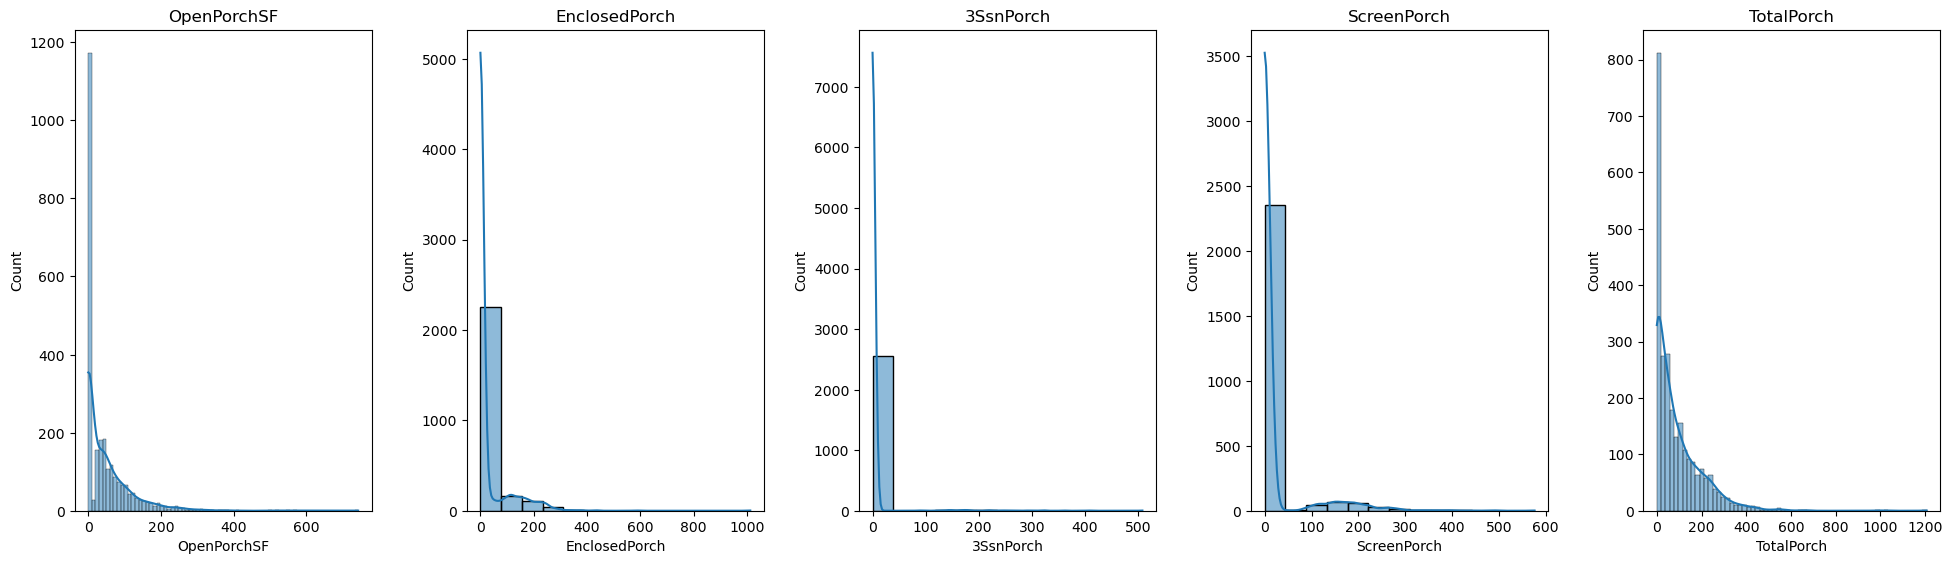

In [135]:
# porch feature frequency distributions
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
axes = axes.flatten()

for i, feature in enumerate(porch_features.columns):
    sns.histplot(x=porch_features[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'{feature}')

plt.tight_layout(pad=2.0) 
plt.show()

See **Ames_Data_Transformations.ipynb** for porch feature analysis.

## How does the model perform with individual porch features, vs a composite TotalPorch feature? 
Model a composite porch feature and component porch features against SalePrice and compare.

### Porch features against SalePrice.

In [139]:
porch_features

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,TotalPorch
0,0,0,0,166,166
1,105,0,0,0,105
2,0,42,86,0,128
3,0,168,0,111,279
4,45,0,0,0,45
...,...,...,...,...,...
2575,98,0,0,40,138
2576,0,0,0,0,0
2577,0,0,0,0,0
2578,96,0,0,0,96


In [140]:
# define features and target
porch4 = ames[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].copy()
y = ames['SalePrice'].copy()
porch4

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,0,0,0,166
1,105,0,0,0
2,0,42,86,0
3,0,168,0,111
4,45,0,0,0
...,...,...,...,...
2575,98,0,0,40
2576,0,0,0,0
2577,0,0,0,0
2578,96,0,0,0


In [141]:
# initialize the model
porch4_model = LinearRegression()

In [142]:
# fit the model
porch4_model.fit(porch4, y)

LinearRegression()

In [143]:
# evaluate the model with kfold
porch4_cv_score = cross_val_score(
    porch4_model, 
    porch4, 
    y, 
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)
porch4_mean_cv_score = round(porch4_cv_score.mean(), 4)

print(f'porch4 cv scores: {porch4_cv_score}')
print(f'porch4 mean cv score: {porch4_mean_cv_score}')

porch4 cv scores: [0.11402688 0.1104844  0.10999362 0.06990213 0.12825863]
porch4 mean cv score: 0.1065


### TotalPorch feature against SalePrice.

In [145]:
# define features and target
total_porch = porch_features[['TotalPorch']].copy()
y = ames['SalePrice'].copy()
total_porch

,TotalPorch
0,166
1,105
2,128
3,279
4,45
...,...
2575,138
2576,0
2577,0
2578,96


In [146]:
# initialize the model
total_porch_model = LinearRegression()

In [147]:
# fit the model
total_porch_model.fit(total_porch, y)

LinearRegression()

In [148]:
# evaluate the model with kfold
total_porch_cv_score = cross_val_score(
    total_porch_model, 
    total_porch, 
    y, 
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)
total_porch_mean_cv_score = round(total_porch_cv_score.mean(), 4)

print(f'total porch cv scores: {total_porch_cv_score}')
print(f'total porch mean cv score: {total_porch_mean_cv_score}')

total porch cv scores: [0.02835133 0.03867169 0.03159372 0.02239405 0.01920851]
total porch mean cv score: 0.028


In [149]:
# For comparison:
print(f'total porch mean cv score: {total_porch_mean_cv_score}')
print(f'porch4 mean cv score: {porch4_mean_cv_score}')

total porch mean cv score: 0.028
porch4 mean cv score: 0.1065


The model performs significantly better with all the porch features. Do not recommend combining them.

# Garage features
[Contents](#Contents)

Can garage features be reduced and combined?

**GarageType** (Nominal): Garage location		
- 2Types	More than one type of garage
- Attchd	Attached to home
- Basment	Basement Garage
- BuiltIn	Built-In (Garage part of house - typically has room above garage)
- CarPort	Car Port
- Detchd	Detached from home
- NA	No Garage
		
**GarageYrBlt** (Discrete): Year garage was built
		
Garage Finish (Ordinal)	: Interior finish of the garage
- Fin	Finished
- RFn	Rough Finished	
- Unf	Unfinished
- NA	No Garage
		
**GarageCars** (Discrete): Size of garage in car capacity

**GarageArea** (Continuous): Size of garage in square feet

**GarageQual** (Ordinal): Garage quality
- Ex	Excellent
- Gd	Good
- TA	Typical/Average
- Fa	Fair
- Po	Poor
- NA	No Garage
		
**GarageCond** (Ordinal): Garage condition
- Ex	Excellent
- Gd	Good
- TA	Typical/Average
- Fa	Fair
- Po	Poor
- NA	No Garage
       
**Questions:**
- GarageCond and GarageQual. Are they related, or associated with one another?
- Are GarageCars and GarageArea related?

### Are GarageCond and GarageQual related or independent? 

H0: GarageCond and GarageQual are not related

HA: GarageCond and GarageQual are related

In [153]:
garage_features = ames[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']].copy()
garage_features.head(2)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Detchd,1939,Unf,2.0,399.0,TA,TA
1,Attchd,1984,Fin,1.0,266.0,TA,TA


Condition for chi2 test:
- **Independence:** The observations must be independent, meaning the occurrence of one outcome shouldn’t affect another. Our dataset satisfies this as each entry represents a distinct house.
- **Sample Size:** The dataset should not only be randomly sampled but also sizable enough to be representative. Our data, sourced from Ames, Iowa, meets this criterion.
- **Expected Frequency:** Every cell in the contingency table should have an expected frequency of at least 5. This is vital for the test’s reliability, as the Chi-squared test relies on a large sample approximation. You will demonstrate this condition below by creating and visualizing the expected frequencies.

source: [Garage or Not? Housing Insights Through the Chi-Squared Test for Ames, Iowa](https://machinelearningmastery.com/chi-squared-ames/)

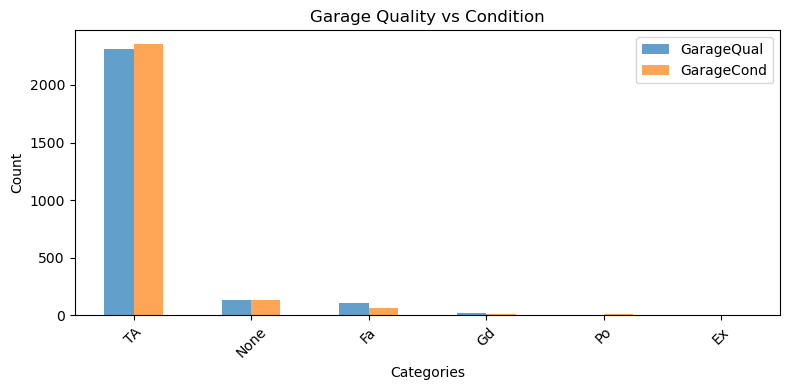

In [155]:
# dataFrame with counts
df_counts = pd.DataFrame({
    'GarageQual': garage_features['GarageQual'].value_counts(),
    'GarageCond': garage_features['GarageCond'].value_counts()
}).fillna(0)

# plot side-by-side bars
df_counts.plot(kind='bar', figsize=(8, 4), alpha=0.7)
plt.title('Garage Quality vs Condition')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [156]:
from scipy.stats import chi2_contingency

In [157]:
# create contingency table
contingency_table = pd.crosstab(garage_features['GarageCond'], garage_features['GarageQual'])
contingency_table

GarageQual,Ex,Fa,Gd,None,Po,TA
GarageCond,,,,,,
Ex,2,0,1,0,0,0
Fa,0,35,0,0,1,31
Gd,0,0,5,0,0,9
None,0,0,0,129,0,0
Po,0,6,0,0,3,2
TA,1,69,16,0,0,2270


This does not satisfy the condition of number of expected frequencies greater than 5.

In [159]:
# category counts for features
print(garage_features['GarageCond'].value_counts())
print(garage_features['GarageQual'].value_counts())

GarageCond
TA      2356
None     129
Fa        67
Gd        14
Po        11
Ex         3
Name: count, dtype: int64
GarageQual
TA      2312
None     129
Fa       110
Gd        22
Po         4
Ex         3
Name: count, dtype: int64


Question: are GarageCond and GarageQual similar enough that we don't need both of them? 
Are they redundant, or related? 

In [161]:
qual_cond = ames[['GarageQual', 'GarageCond']].copy()
qual_cond.head(2)

,GarageQual,GarageCond
0,TA,TA
1,TA,TA


In [162]:
qual_cond['AboveAverageQual'] = '--'
qual_cond['AboveAverageCond'] = '--'
qual_cond.head(2)

,GarageQual,GarageCond,AboveAverageQual,AboveAverageCond
0,TA,TA,--,--
1,TA,TA,--,--


In [163]:
qual_cond.loc[qual_cond['GarageQual'].isin(['TA', 'Gd', 'Ex']), 'AboveAverageQual'] = 'Y'
qual_cond.loc[qual_cond['GarageQual'].isin(['Fa', 'Po', 'NA']), 'AboveAverageQual'] = 'N'

qual_cond.loc[qual_cond['GarageCond'].isin(['TA', 'Gd', 'Ex']), 'AboveAverageCond'] = 'Y'
qual_cond.loc[qual_cond['GarageCond'].isin(['Fa', 'Po', 'NA']), 'AboveAverageCond'] = 'N'

In [164]:
qual_cond.head(5)

,GarageQual,GarageCond,AboveAverageQual,AboveAverageCond
0,TA,TA,Y,Y
1,TA,TA,Y,Y
2,TA,Po,Y,N
3,TA,TA,Y,Y
4,TA,TA,Y,Y


In [165]:
# create observed frequency table
qual_cond_contingency_table = pd.crosstab(qual_cond['AboveAverageCond'],
                                          qual_cond['AboveAverageQual'])
qual_cond_contingency_table

AboveAverageQual,--,N,Y
AboveAverageCond,,,
--,129,0,0
N,0,45,33
Y,0,69,2304


In [166]:
# create observed frequency table dataframe
print("Observed Frequencies:")
qual_cond_observed_df = pd.DataFrame(qual_cond_contingency_table,
                           index=['N', 'Y'],
                           columns=['N', 'Y'])
print(qual_cond_observed_df)

Observed Frequencies:
    N     Y
N  45    33
Y  69  2304


More than 5 counts per cell.

For houses with GarageQual and GarageCond either above or below average:

H0: houses with above average GarageQual often have above average GarageCond.

HA: house with above average GarageQual are not associated with above average GarageCond.

In [169]:
# performing the chi-squared test
chi2_stat, p_value, _, expected_freq = chi2_contingency(qual_cond_observed_df)
 
# print expected frequencies
print("Expected Frequencies:")
print(pd.DataFrame(expected_freq,
                   index=['N', 'Y'],
                   columns=['N', 'Y']).round(1))
print()

print(f"Chi-squared Statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4e}")

Expected Frequencies:
       N       Y
N    3.6    74.4
Y  110.4  2262.6

Chi-squared Statistic: 498.8015
p-value: 1.7327e-110


The expected frequencies represent what we would expect if there is no relationship between AboveAverageQual and AboveAverageCond. The observed frequencies are what we actually see. They are quite different. **GarageQual and GarageCond are related.**   

Does this mean that they can be combined in a meaningful way? 

In [171]:
print(qual_cond['AboveAverageQual'].value_counts())
print(qual_cond['AboveAverageCond'].value_counts())

AboveAverageQual
Y     2337
--     129
N      114
Name: count, dtype: int64
AboveAverageCond
Y     2373
--     129
N       78
Name: count, dtype: int64


In [172]:
# number of houses with below average Qual and below Average Cond
print(len(qual_cond.query("AboveAverageCond != 'Y' and AboveAverageQual != 'Y' and AboveAverageQual != '--'")))
qual_cond.query("AboveAverageCond != 'Y' and AboveAverageQual != 'Y' and AboveAverageQual != '--'")

45


,GarageQual,GarageCond,AboveAverageQual,AboveAverageCond
110,Fa,Fa,N,N
127,Po,Fa,N,N
221,Fa,Fa,N,N
267,Fa,Po,N,N
301,Fa,Fa,N,N
371,Fa,Fa,N,N
405,Fa,Fa,N,N
427,Fa,Fa,N,N
474,Fa,Fa,N,N
510,Po,Po,N,N


In [173]:
qual_cond.query("AboveAverageCond != 'Y' and AboveAverageQual != 'Y'").head(50)

,GarageQual,GarageCond,AboveAverageQual,AboveAverageCond
17,None,None,--,--
22,None,None,--,--
44,None,None,--,--
48,None,None,--,--
50,None,None,--,--
54,None,None,--,--
60,None,None,--,--
93,None,None,--,--
106,None,None,--,--
107,None,None,--,--


**For later:** can look at Cohen's d for a statistical understanding of the difference between GarageQual and GarageCond.

### Comparing model performance for GarageQual and GarageCond
Do GarageQual and GarageCond contribute simliarly to model performance? 

1. Regress GarageQual on SalePrice
2. Regress GarageCond on SalePrice
3. Regress GarageQual and GarageCond on SalePrice

Compare R2 scores

### Evaluate GarageCond against SalePrice

In [177]:
cond = ames[['GarageCond']].copy()
y = ames['SalePrice'].copy()

In [178]:
cond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   GarageCond  2580 non-null   object
dtypes: object(1)
memory usage: 20.3+ KB


In [179]:
cond.head(2)

,GarageCond
0,TA
1,TA


In [180]:
# Initialize encoder
cond_encoder = OneHotEncoder(sparse_output=False)

In [181]:
# One hot encode the feature
cond_encoded_cols = cond_encoder.fit_transform(cond)
cond_encoded_cols

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [182]:
cond_encoder.get_feature_names_out(['GarageCond'])

array(['GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd',
       'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA'], dtype=object)

In [183]:
cond_categories = cond_encoder.categories_
cond_categories

[array(['Ex', 'Fa', 'Gd', 'None', 'Po', 'TA'], dtype=object)]

In [184]:
# Create dataframe with encoded data
cond_encoded_df = pd.DataFrame(cond_encoded_cols, columns=cond_categories)
cond_encoded_df

,Ex,Fa,Gd,None,Po,TA
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2575,0.0,0.0,0.0,0.0,1.0,0.0
2576,0.0,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,0.0,1.0


In [185]:
# Change the naming convention for the array... 
cond_encoded_df = pd.DataFrame(
    data    = cond_encoded_cols,
    columns = cond_encoder.get_feature_names_out(['GarageCond']),
    index   = cond.index
) 

In [186]:
cond_encoded_df

,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2575,0.0,0.0,0.0,0.0,1.0,0.0
2576,0.0,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,0.0,1.0


In [187]:
cond.value_counts()

GarageCond
TA            2356
None           129
Fa              67
Gd              14
Po              11
Ex               3
Name: count, dtype: int64

In [188]:
# based on low counts, drop GarageCond_Ex column
cond_encoded_df = cond_encoded_df.drop(columns=['GarageCond_Ex'])
cond_encoded_df

,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
2575,0.0,0.0,0.0,1.0,0.0
2576,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,1.0


In [189]:
# initialize the model
cond_model = LinearRegression()

In [190]:
# fit the model
cond_model.fit(cond_encoded_df, y)

LinearRegression()

In [191]:
cond_score = cond_model.score(cond_encoded_df, y)
print(f'cond score: {cond_score}')

cond score: 0.07822268445581049


In [192]:
# evaluate the model
cond_cv_score = cross_val_score(cond_model, cond_encoded_df, y)
cond_mean_cv_score = round(cond_cv_score.mean(), 4)
print(f'cond cv scores: {cond_cv_score}')
print(f'cond mean cv score: {cond_mean_cv_score}')

cond cv scores: [0.08180185 0.06125364 0.07064019 0.06003499 0.06032901]
cond mean cv score: 0.0668


In [193]:
# evaluate the model with kfold
cond_cv_score1 = cross_val_score(
    cond_model, 
    cond_encoded_df, 
    y, 
    # in order to compare with Vinod's result
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)
cond_mean_cv_score1 = round(cond_cv_score1.mean(), 4)

print(f'cond cv scores with random shuffling: {cond_cv_score1}')
print(f'cond mean cv score with random shuffling: {cond_mean_cv_score1}')

cond cv scores with random shuffling: [0.06504451 0.06633785 0.07905567 0.08530251 0.06362985]
cond mean cv score with random shuffling: 0.0719


### Evaluate GarageQual against SalePrice

In [195]:
qual = ames[['GarageQual']].copy()
y = ames['SalePrice'].copy()

In [196]:
# Initialize encoder
qual_encoder = OneHotEncoder(sparse_output=False)

In [197]:
# One hot encode the feature
qual_encoded_cols = qual_encoder.fit_transform(qual)
qual_encoded_cols

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [198]:
qual_encoder.get_feature_names_out(['GarageQual'])

array(['GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd',
       'GarageQual_None', 'GarageQual_Po', 'GarageQual_TA'], dtype=object)

In [199]:
qual_categories = qual_encoder.categories_
qual_categories

[array(['Ex', 'Fa', 'Gd', 'None', 'Po', 'TA'], dtype=object)]

In [200]:
# Create dataframe with encoded data
qual_encoded_df = pd.DataFrame(qual_encoded_cols, columns=qual_categories)
qual_encoded_df

,Ex,Fa,Gd,None,Po,TA
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2575,0.0,1.0,0.0,0.0,0.0,0.0
2576,0.0,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,0.0,1.0


In [201]:
# Change the naming convention for the array... 
qual_encoded_df = pd.DataFrame(
    data    = qual_encoded_cols,
    columns = qual_encoder.get_feature_names_out(['GarageQual']),
    index   = qual.index
) 

In [202]:
qual_encoded_df

,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2575,0.0,1.0,0.0,0.0,0.0,0.0
2576,0.0,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,0.0,1.0


In [203]:
qual.value_counts()

GarageQual
TA            2312
None           129
Fa             110
Gd              22
Po               4
Ex               3
Name: count, dtype: int64

In [204]:
# based on low counts, drop GarageCond_Ex column
qual_encoded_df = qual_encoded_df.drop(columns=['GarageQual_Ex'])
qual_encoded_df

,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
2575,1.0,0.0,0.0,0.0,0.0
2576,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,1.0


In [205]:
# initialize the model
qual_model = LinearRegression()

In [206]:
# fit the model
qual_model.fit(qual_encoded_df, y)

LinearRegression()

In [207]:
# evaluate the model
qual_score = cross_val_score(qual_model, qual_encoded_df, y)
qual_mean_score = round(qual_score.mean(), 4)
print(f'qual cross_val_scores: {qual_score}')
print(f'qual mean score: {qual_mean_score}')

qual cross_val_scores: [0.08118997 0.05958356 0.0820685  0.0687021  0.05743945]
qual mean score: 0.0698


In [208]:
print(f'cond mean cv score: {cond_mean_cv_score}')

cond mean cv score: 0.0668


In [209]:
# evaluate the model with kfold
qual_cv_score1 = cross_val_score(
    qual_model, 
    qual_encoded_df, 
    y, 
    # in order to compare with Vinod's result
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)
qual_mean_cv_score1 = round(qual_cv_score1.mean(), 4)

print(f'qual cv scores with random shuffling: {qual_cv_score1}')
print(f'qual mean cv score with random shuffling: {qual_mean_cv_score1}')

qual cv scores with random shuffling: [0.06693798 0.05999738 0.04852267 0.11716831 0.06309891]
qual mean cv score with random shuffling: 0.0711


### Evaluate GarageCond and GarageQual against SalePrice

In [211]:
cond_qual = ames[['GarageCond', 'GarageQual']].copy()
y = ames['SalePrice'].copy()

In [212]:
# Initialize encoder
cond_qual_encoder = OneHotEncoder(sparse_output=False)

In [213]:
# One hot encode the feature
cond_qual_encoded_cols = cond_qual_encoder.fit_transform(cond_qual)
cond_qual_encoded_cols

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [214]:
cond_qual_feature_names = cond_qual_encoder.get_feature_names_out(['GarageCond', 'GarageQual'])
print(cond_qual_feature_names.shape)
cond_qual_feature_names

(12,)


array(['GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd',
       'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA',
       'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd',
       'GarageQual_None', 'GarageQual_Po', 'GarageQual_TA'], dtype=object)

In [215]:
# cond_qual_categories = cond_qual_encoder.categories_
# cond_qual_categories

In [216]:
# Create dataframe with encoded data
cond_qual_encoded_df = pd.DataFrame(cond_qual_encoded_cols, columns=cond_qual_feature_names)
cond_qual_encoded_df

,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2575,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2576,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [217]:
# Change the naming convention for the array... 
cond_qual_encoded_df = pd.DataFrame(
    data    = cond_qual_encoded_cols,
    columns = cond_qual_encoder.get_feature_names_out(['GarageCond', 'GarageQual']),
    index   = cond_qual.index
) 

In [218]:
cond_qual_encoded_df

,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2575,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2576,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


That looks right

In [220]:
# drop Ex category from both features to handle multicollinearity
cond_qual_encoded_df = cond_qual_encoded_df.drop(columns=['GarageCond_Ex', 'GarageQual_Ex'])
cond_qual_encoded_df

,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2575,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2576,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2577,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2578,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [221]:
# initialize the model
cond_qual_model = LinearRegression()

In [222]:
# fit the model
cond_qual_model.fit(cond_qual_encoded_df, y)

LinearRegression()

In [223]:
cond_qual_score = cond_qual_model.score(cond_qual_encoded_df, y)
print(f'cond qual score: {cond_qual_score}')

cond qual score: 0.1024825508049162


In [224]:
print(f'cond score: {cond_score}')
print(f'qual score: {qual_score}')

cond score: 0.07822268445581049
qual score: [0.08118997 0.05958356 0.0820685  0.0687021  0.05743945]


In [225]:
# evaluate the model with kfold
cond_qual_cv_score1 = cross_val_score(
    cond_qual_model, 
    cond_qual_encoded_df, 
    y, 
    # in order to compare with Vinod's result
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)
cond_qual_mean_cv_score1 = round(cond_qual_cv_score1.mean(), 4)

print(f'cond_qual cv scores with random shuffling: {cond_qual_cv_score1}')
print(f'cond_qual mean cv score with random shuffling: {cond_qual_mean_cv_score1}')

cond_qual cv scores with random shuffling: [0.08547773 0.09490328 0.06276859 0.11903337 0.07339094]
cond_qual mean cv score with random shuffling: 0.0871


In [226]:
# evaluate the model - without random shuffling. banana fold
cond_qual_cv_score = cross_val_score(cond_qual_model, cond_qual_encoded_df, y)
cond_qual_mean_cv_score = round(cond_qual_cv_score.mean(), 4)
print(f'cond_qual cv scores without random shuffling: {cond_qual_cv_score}')
print(f'cond_qual mean cv score without random shuffling: {cond_qual_mean_cv_score}')

cond_qual cv scores without random shuffling: [ 9.67105969e-02  8.03789648e-02  8.59601161e-02 -9.53572600e+21
  6.75865014e-02]
cond_qual mean cv score without random shuffling: -1.907145199777961e+21


Shuffling the data fixes this issue... 

In [228]:
# Comparing scores
print(f'cond mean cv score: {cond_mean_cv_score1}')
print(f'qual mean cv score: {qual_mean_cv_score1}')
print(f'cond_qual mean cv score with random shuffling: {cond_qual_mean_cv_score1}')

cond mean cv score: 0.0719
qual mean cv score: 0.0711
cond_qual mean cv score with random shuffling: 0.0871


#### Why is this one fold so weird? 
The following portion of the notebook was spent trying to understand why one fold had such a horrendous score. This is backtracked above as well, ultimately fixed with random shuffling. 

In [230]:
print(ames['GarageCond'].value_counts())
print(ames['GarageQual'].value_counts())

GarageCond
TA      2356
None     129
Fa        67
Gd        14
Po        11
Ex         3
Name: count, dtype: int64
GarageQual
TA      2312
None     129
Fa       110
Gd        22
Po         4
Ex         3
Name: count, dtype: int64


In [231]:
ames[ames['GarageQual']=='Po']

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
127,1049,80900,50,C (all),52.0,5150,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,5,2008,WD,Normal
510,1112,63000,50,RL,60.0,9780,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,3,2009,WD,Normal
579,789,96500,45,RL,55.0,10594,Pave,None,Reg,Lvl,...,0,0,None,MnPrv,None,0,6,2007,WD,Normal
1050,1928,137000,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,None,None,None,0,4,2006,WD,Normal


**For later, from Vinod:** 

Check if there are categories missing entirely from any of the testing sets.

Track category distribution among folds and check for balance. Column sums show how many instances of each category appear in each train/test split. 

In [233]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(kf.split(cond_qual_encoded_df)):
    X_train, X_test = cond_qual_encoded_df.iloc[train_idx], cond_qual_encoded_df.iloc[test_idx]

    print(f"\nFold {i+1}")
    print("Train column sums:")
    print(X_train.sum())
    print("Test column sums:")
    print(X_test.sum())


Fold 1
Train column sums:
GarageCond_Fa        55.0
GarageCond_Gd        11.0
GarageCond_None     102.0
GarageCond_Po         7.0
GarageCond_TA      1886.0
GarageQual_Fa        87.0
GarageQual_Gd        17.0
GarageQual_None     102.0
GarageQual_Po         2.0
GarageQual_TA      1853.0
dtype: float64
Test column sums:
GarageCond_Fa       12.0
GarageCond_Gd        3.0
GarageCond_None     27.0
GarageCond_Po        4.0
GarageCond_TA      470.0
GarageQual_Fa       23.0
GarageQual_Gd        5.0
GarageQual_None     27.0
GarageQual_Po        2.0
GarageQual_TA      459.0
dtype: float64

Fold 2
Train column sums:
GarageCond_Fa        57.0
GarageCond_Gd        11.0
GarageCond_None     107.0
GarageCond_Po         9.0
GarageCond_TA      1878.0
GarageQual_Fa        95.0
GarageQual_Gd        20.0
GarageQual_None     107.0
GarageQual_Po         3.0
GarageQual_TA      1837.0
dtype: float64
Test column sums:
GarageCond_Fa       10.0
GarageCond_Gd        3.0
GarageCond_None     22.0
GarageCond_Po       

Manually run the model on each fold and track the score. This gives us control and lets us inspect that one “banana” fold directly:

In [235]:
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=5)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

for i, (train_idx, test_idx) in enumerate(kf.split(cond_qual_encoded_df)):
    X_train, X_test = cond_qual_encoded_df.iloc[train_idx], cond_qual_encoded_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    print(f"Fold {i+1} R² Score: {score:.4f}")
    fold_scores.append(score)

Fold 1 R² Score: 0.0967
Fold 2 R² Score: 0.0804
Fold 3 R² Score: 0.0860
Fold 4 R² Score: -9535725998889804759040.0000
Fold 5 R² Score: 0.0676


In [236]:
print(X_test.head())
print(y_test.head())

      GarageCond_Fa  GarageCond_Gd  GarageCond_None  GarageCond_Po  \
2064            0.0            0.0              0.0            0.0   
2065            0.0            0.0              0.0            0.0   
2066            0.0            0.0              0.0            0.0   
2067            0.0            0.0              0.0            0.0   
2068            1.0            0.0              0.0            0.0   

      GarageCond_TA  GarageQual_Fa  GarageQual_Gd  GarageQual_None  \
2064            1.0            0.0            0.0              0.0   
2065            1.0            0.0            0.0              0.0   
2066            1.0            0.0            0.0              0.0   
2067            1.0            0.0            0.0              0.0   
2068            0.0            1.0            0.0              0.0   

      GarageQual_Po  GarageQual_TA  
2064            0.0            1.0  
2065            0.0            1.0  
2066            0.0            1.0  
2067      

**Note:** without shuffling, the categorical distribution is imbalanced, leaving 'Po' categories out of fold 4 entirely. This is why the R2 score is so bad. When shuffling and a random state are set, the distribution corrects by chance and 'Po' categories are represented in every fold, giving more reasonable results. 

In [238]:
print(f'cond cv scores with random shuffling: {cond_cv_score1}')
print(f'cond mean cv score with random shuffling: {cond_mean_cv_score1}')

print(f'qual cv scores with random shuffling: {qual_cv_score1}')
print(f'qual mean cv score with random shuffling: {qual_mean_cv_score1}')

print(f'cond_qual cv scores with random shuffling: {cond_qual_cv_score1}')
print(f'cond_qual mean cv score with random shuffling: {cond_qual_mean_cv_score1}')

cond cv scores with random shuffling: [0.06504451 0.06633785 0.07905567 0.08530251 0.06362985]
cond mean cv score with random shuffling: 0.0719
qual cv scores with random shuffling: [0.06693798 0.05999738 0.04852267 0.11716831 0.06309891]
qual mean cv score with random shuffling: 0.0711
cond_qual cv scores with random shuffling: [0.08547773 0.09490328 0.06276859 0.11903337 0.07339094]
cond_qual mean cv score with random shuffling: 0.0871


### Summary:
The model does perform better with both GarageCond and GarageQual.

But only if the distribution of categories is balanced during evaluation. This is not guaranteed. 
Does this mean that having both features in the model could be problematic? 

**When OneHotEncoding, drop the 'Ex' category to not compound this issue.**

*Is it beneficial to the model to control which categories are dropped?*

### GarageCars and GarageArea 

In [241]:
garage_features.head(2)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Detchd,1939,Unf,2.0,399.0,TA,TA
1,Attchd,1984,Fin,1.0,266.0,TA,TA


In [242]:
garage_features['GarageCars'].value_counts()

GarageCars
2.0    1440
1.0     713
3.0     285
0.0     127
4.0      14
5.0       1
Name: count, dtype: int64

In [243]:
garage_features.groupby('GarageCars')['GarageArea'].mean()

GarageCars
0.0       0.000000
1.0     299.939691
2.0     517.631250
3.0     807.680702
4.0     988.714286
5.0    1184.000000
Name: GarageArea, dtype: float64

In [244]:
garage_features[['GarageCars', 'GarageArea']].corr()

,GarageCars,GarageArea
GarageCars,1.000000,0.889587
GarageArea,0.889587,1.000000


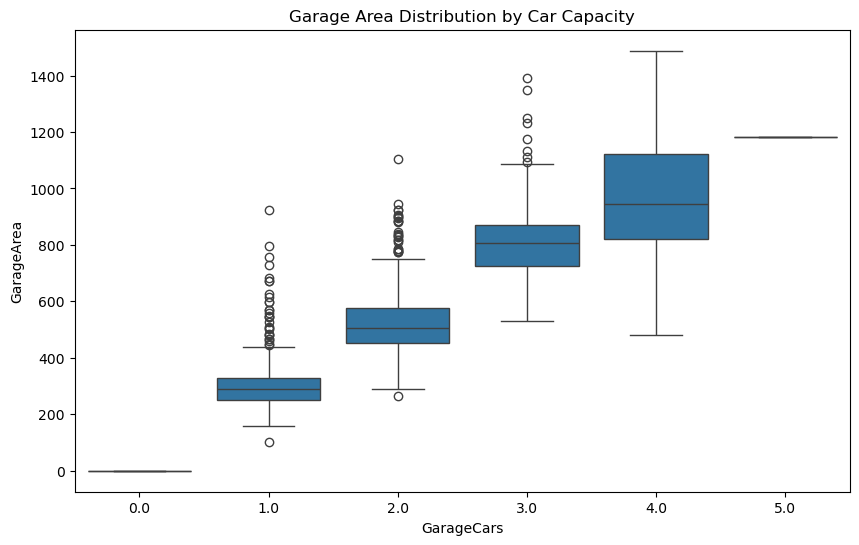

In [245]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=garage_features, x='GarageCars', y='GarageArea')
plt.title('Garage Area Distribution by Car Capacity')
plt.show()

# Bathroom features
[Contents](#Contents)

- Bsmt Full Bath (Discrete): Basement full bathrooms
- Bsmt Half Bath (Discrete): Basement half bathrooms
- Full Bath (Discrete): Full bathrooms above grade
- Half Bath (Discrete): Half baths above grade


Would it be useful to combine full and half basement baths --> 1.5 bathrooms? (also for above grade)

In [247]:
bath_features = ames[['SalePrice', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].copy()
bath_features

,SalePrice,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
0,126000,1.0,0.0,1,0
1,139500,1.0,0.0,2,0
2,124900,0.0,0.0,1,0
3,114000,0.0,0.0,1,0
4,227000,1.0,0.0,2,1
...,...,...,...,...,...
2575,121000,0.0,0.0,1,0
2576,139600,0.0,0.0,2,0
2577,145000,0.0,0.0,2,0
2578,217500,1.0,0.0,2,1


In [248]:
bath_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SalePrice     2580 non-null   int64  
 1   BsmtFullBath  2580 non-null   float64
 2   BsmtHalfBath  2580 non-null   float64
 3   FullBath      2580 non-null   int64  
 4   HalfBath      2580 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 100.9 KB


In [249]:
bath_features.corr()

,SalePrice,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
SalePrice,1.000000,0.290755,-0.033786,0.534982,0.285875
BsmtFullBath,0.290755,1.000000,-0.163850,-0.023238,-0.050075
BsmtHalfBath,-0.033786,-0.163850,1.000000,-0.038143,-0.068404
FullBath,0.534982,-0.023238,-0.038143,1.000000,0.172807
HalfBath,0.285875,-0.050075,-0.068404,0.172807,1.000000


Bathroom features are not strongly correlated with one another.
Why not create a bathroom feature that include .5 bath info? 
Same with Bsmt Bath. Go from 4 features to 2 features and not lose any data.

In [251]:
bath_features.head(5)

,SalePrice,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
0,126000,1.0,0.0,1,0
1,139500,1.0,0.0,2,0
2,124900,0.0,0.0,1,0
3,114000,0.0,0.0,1,0
4,227000,1.0,0.0,2,1


In [252]:
bath_features['HalfBath'].value_counts()

HalfBath
0    1622
1     940
2      18
Name: count, dtype: int64

In [253]:
bath_features['BsmtHalfBath'].value_counts()

BsmtHalfBath
0.0    2422
1.0     156
2.0       2
Name: count, dtype: int64

*See also Ames_Base_Model2.ipynb for bathroom feature engineering and scoring*

## Basement features 
[Contents](#Contents)

**BsmtQual** (Ordinal): Evaluates the height of the basement
- Ex	Excellent (100+ inches)	
- Gd	Good (90-99 inches)
- TA	Typical (80-89 inches)
- Fa	Fair (70-79 inches)
- Po	Poor (<70 inches
- NA	No Basement
		
**BsmtCond** (Ordinal): Evaluates the general condition of the basement
- Ex	Excellent
- Gd	Good
- TA	Typical - slight dampness allowed
- Fa	Fair - dampness or some cracking or settling
- Po	Poor - Severe cracking, settling, or wetness
- NA	No Basement

**BsmtExposure**	(Ordinal): Refers to walkout or garden level walls
- Gd	Good Exposure
- Av	Average Exposure (split levels or foyers typically score average or above)	
- Mn	Mimimum Exposure
- No	No Exposure
- NA	No Basement
	
**BsmtFinType1**	(Ordinal): Rating of basement finished area
- GLQ	Good Living Quarters
- ALQ	Average Living Quarters
- BLQ	Below Average Living Quarters	
- Rec	Average Rec Room
- LwQ	Low Quality
- Unf	Unfinshed
- NA	No Basement

**BsmtFinSF1** (Continuous): Type 1 finished square feet

**BsmtFinType2**	(Ordinal): Rating of basement finished area (if multiple types)
- GLQ	Good Living Quarters
- ALQ	Average Living Quarters
- BLQ	Below Average Living Quarters	
- Rec	Average Rec Room
- LwQ	Low Quality
- Unf	Unfinshed
- NA	No Basement

**BsmtFinSF2** (Continuous): Type 2 finished square feet

**BsmtUnfSF** (Continuous): Unfinished square feet of basement area

**TotalBsmtSF** (Continuous): Total square feet of basement area       

In [256]:
basement_features = ames[[
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 
    'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'    
]].copy()
basement_features.head(2)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0
1,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0


In [257]:
# categorical features
print(basement_features['BsmtQual'].value_counts())
print(basement_features['BsmtCond'].value_counts())
print(basement_features['BsmtExposure'].value_counts())
print(basement_features['BsmtFinType1'].value_counts())
print(basement_features['BsmtFinType2'].value_counts())

BsmtQual
TA      1166
Gd      1077
Ex       188
Fa        78
None      69
Po         2
Name: count, dtype: int64
BsmtCond
TA      2316
Gd       101
Fa        88
None      69
Ex         3
Po         3
Name: count, dtype: int64
BsmtExposure
No      1708
Av       344
Gd       242
Mn       215
None      71
Name: count, dtype: int64
BsmtFinType1
GLQ     753
Unf     706
ALQ     397
Rec     265
BLQ     251
LwQ     139
None     69
Name: count, dtype: int64
BsmtFinType2
Unf     2180
Rec       97
LwQ       84
None      70
BLQ       64
ALQ       53
GLQ       32
Name: count, dtype: int64


<Axes: xlabel='BsmtQual', ylabel='SalePrice'>

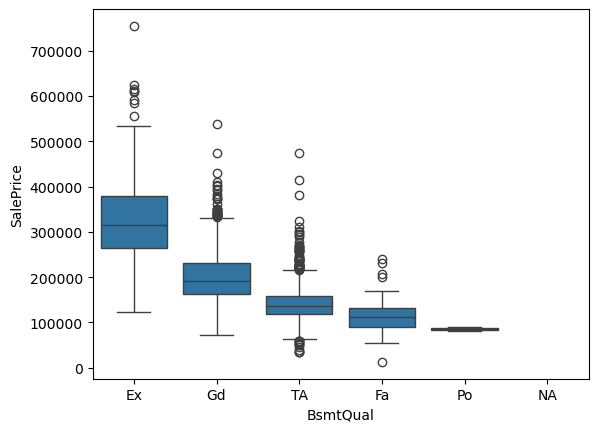

In [258]:
quality_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
sns.boxplot(x=basement_features['BsmtQual'], y=ames['SalePrice'], order=quality_order)

<Axes: xlabel='BsmtCond', ylabel='SalePrice'>

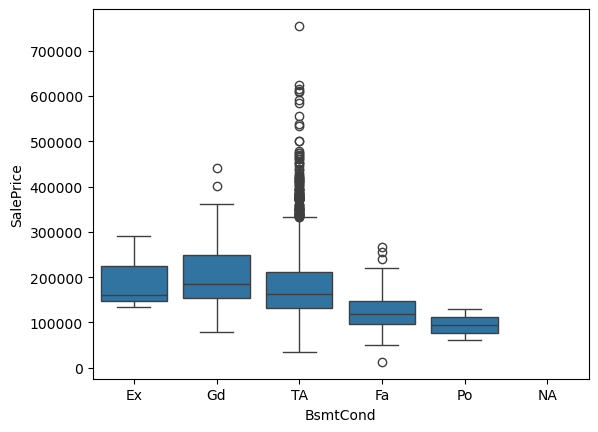

In [259]:
quality_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
sns.boxplot(x=basement_features['BsmtCond'], y=ames['SalePrice'], order=quality_order)

<Axes: xlabel='BsmtExposure', ylabel='SalePrice'>

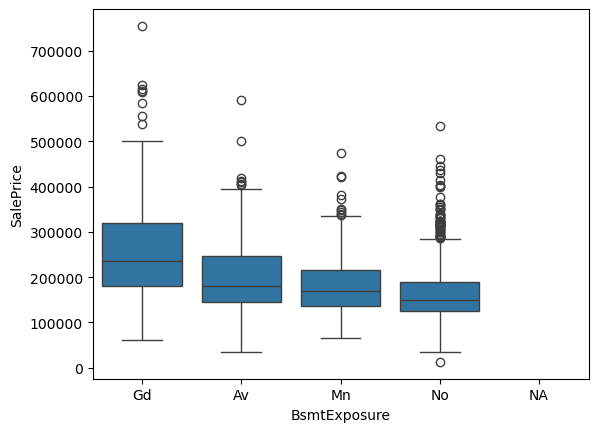

In [260]:
quality_order = ['Gd', 'Av', 'Mn', 'No', 'NA']
sns.boxplot(data=ames, x='BsmtExposure', y='SalePrice', order=quality_order)

<Axes: xlabel='BsmtFinType1', ylabel='SalePrice'>

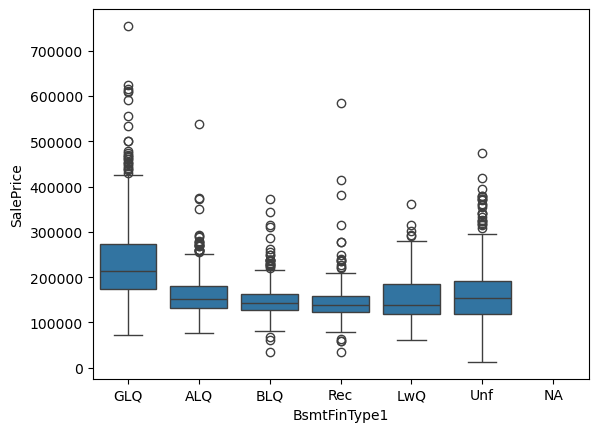

In [261]:
quality_order = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
sns.boxplot(data=ames, x='BsmtFinType1', y='SalePrice', order=quality_order)

<Axes: xlabel='BsmtFinType2', ylabel='SalePrice'>

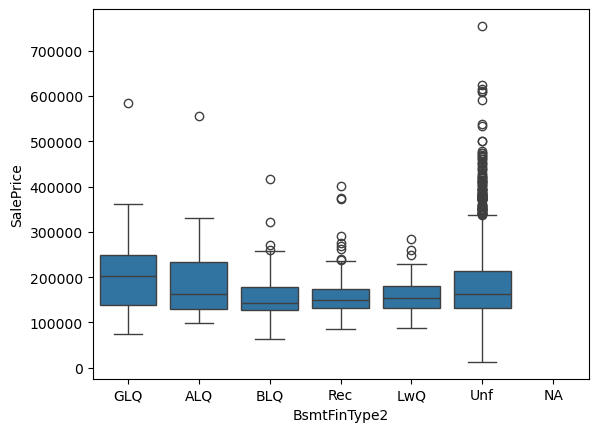

In [262]:
quality_order = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
sns.boxplot(data=ames, x='BsmtFinType2', y='SalePrice', order=quality_order)

# Numeric base model
[Contents](#Contents)

*see Ames_Base_Model_final.ipynb notebook* 

# Data transformations
[Contents](#Contents)

- 1st Question: does transforming the target improve the model? If so:
- 2nd Question: does transforming the features improve the model?

Compare models with untransformed features against: 
- SalePrice
- log(SalePrice)

- model 1: no transformation
- model 2: transform target
- model 3: transform target and highly skewed features

can apply log transform to any features I want, regardless of skew. Can transform all the skewed features, and not SalePrice. 

What is the impact to r2 scores? 

*see Ames_Base_Model3* and feature selection section for more notes on log transformation of SalePrice

# Feature selection
[Contents](#Contents)

See *Ames_Data_Transformations.ipynb*

Apply SequentialFeatureSelector to investigate most predictive, numerical features.

# Categorical features
[Contents](#Contents)

Add all the categorical features into the log-linear sfs-reduced numeric model.
*see Ames_Data_Transformations.ipynb*

How does the model perform with the reduced numeric set (the most predictive numeric features suggested by Sequential Feature Selector):

In [268]:
# define sfs-reduced, numeric dataframe
num_red = ames[['GrLivArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 
           'KitchenAbvGr', 'Fireplaces', 'GarageArea']].copy()
num_red.head(2)

,GrLivArea,YearBuilt,YearRemodAdd,TotalBsmtSF,KitchenAbvGr,Fireplaces,GarageArea
0,856,1939,1950,856.0,1,1,399.0
1,1049,1984,1984,1049.0,1,0,266.0


In [269]:
ordinal_features

,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009
2,SBrkr,Reg,AllPub,Gtl,5,9,Gd,TA,TA,TA,...,Typ,None,Unf,TA,Po,N,None,None,11,2007
3,SBrkr,Reg,AllPub,Gtl,4,8,Gd,Gd,Fa,TA,...,Typ,None,Unf,TA,TA,N,None,None,5,2009
4,SBrkr,Reg,AllPub,Gtl,8,6,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,11,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,FuseF,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,Fa,Po,P,None,None,5,2009
2576,FuseA,IR1,AllPub,Gtl,3,5,TA,TA,None,None,...,Min2,Gd,Unf,TA,TA,Y,None,None,6,2009
2577,FuseA,Reg,AllPub,Gtl,5,6,TA,TA,TA,TA,...,Typ,None,Unf,TA,TA,Y,None,None,8,2007
2578,SBrkr,Reg,AllPub,Gtl,7,5,Gd,TA,Gd,TA,...,Typ,TA,Fin,TA,TA,Y,None,None,7,2007


In [270]:
cat_df = ames.select_dtypes(include=['object'])
cat_df

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,30,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,120,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,TA,TA,Y,None,None,None,2,2009,WD,Normal
2,30,C (all),Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,TA,Po,N,None,None,None,11,2007,WD,Normal
3,70,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,OldTown,...,TA,TA,N,None,None,None,5,2009,WD,Normal
4,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,TA,TA,Y,None,None,None,11,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,30,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,...,Fa,Po,P,None,None,None,5,2009,WD,Normal
2576,20,RL,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,...,TA,TA,Y,None,None,None,6,2009,WD,Normal
2577,90,RH,Pave,None,Reg,HLS,AllPub,Inside,Gtl,Crawfor,...,TA,TA,Y,None,None,None,8,2007,WD,Normal
2578,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,TA,Y,None,None,None,7,2007,WD,Normal


In [271]:
# combine reduced, numeric features and categorical features into reduced df
red = num_red.join(cat_df)
red

,GrLivArea,YearBuilt,YearRemodAdd,TotalBsmtSF,KitchenAbvGr,Fireplaces,GarageArea,MSSubClass,MSZoning,Street,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,856,1939,1950,856.0,1,1,399.0,30,RL,Pave,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,1049,1984,1984,1049.0,1,0,266.0,120,RL,Pave,...,TA,TA,Y,None,None,None,2,2009,WD,Normal
2,1001,1930,2007,837.0,1,0,216.0,30,C (all),Pave,...,TA,Po,N,None,None,None,11,2007,WD,Normal
3,1039,1900,2003,405.0,1,0,281.0,70,RL,Pave,...,TA,TA,N,None,None,None,5,2009,WD,Normal
4,1665,2001,2001,810.0,1,0,528.0,60,RL,Pave,...,TA,TA,Y,None,None,None,11,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,952,1916,1950,952.0,1,1,192.0,30,RL,Pave,...,Fa,Po,P,None,None,None,5,2009,WD,Normal
2576,1733,1955,1955,0.0,1,1,452.0,20,RL,Pave,...,TA,TA,Y,None,None,None,6,2009,WD,Normal
2577,2002,1949,1950,1001.0,2,0,871.0,90,RH,Pave,...,TA,TA,Y,None,None,None,8,2007,WD,Normal
2578,1842,2000,2000,985.0,1,1,486.0,60,RL,Pave,...,TA,TA,Y,None,None,None,7,2007,WD,Normal


In [272]:
# define features and target for modeling
X_red = red.copy()
y = ames['SalePrice']

In [273]:
num_red_list = num_red.columns.to_list()

In [274]:
cat_df_list = cat_df.columns.to_list()

In [275]:
# Set up preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', 'passthrough', num_red_list),
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_df_list)
])

In [276]:
# fit the model
model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

In [277]:
model.fit(X_red, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['GrLivArea', 'YearBuilt',
                                                   'YearRemodAdd',
                                                   'TotalBsmtSF',
                                                   'KitchenAbvGr', 'Fireplaces',
                                                   'GarageArea']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'OverallQual', 'OverallCond',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating', ...])])),
                ('regressor', LinearRegression())])

In [278]:
# evaluate the model
cv_scores = cross_val_score(model, X_red, y)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

In [279]:
mean_cv_score = float(round(cv_scores.mean(), 4))
print(f'7-feature numeric model and all categorical features')
print(f'mean cv score: {mean_cv_score}')
print(f'cv scores: {cv_scores}')

7-feature numeric model and all categorical features
mean cv score: 0.9034
cv scores: [0.87154717 0.91172394 0.91092683 0.9140287  0.90871257]


### run on log-linear model:

In [281]:
num_red_list = num_red.columns.to_list()

In [282]:
cat_df_list = cat_df.columns.to_list()

In [283]:
# Set up preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', 'passthrough', num_red_list),
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_df_list)
])

In [284]:
# fit the model
model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

In [285]:
model.fit(X_red, np.log10(y))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['GrLivArea', 'YearBuilt',
                                                   'YearRemodAdd',
                                                   'TotalBsmtSF',
                                                   'KitchenAbvGr', 'Fireplaces',
                                                   'GarageArea']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'OverallQual', 'OverallCond',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating', ...])])),
                ('regressor', LinearRegression())])

In [286]:
# evaluate the model
cv_scores = cross_val_score(model, X_red, np.log10(y))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

In [287]:
mean_cv_score = float(round(cv_scores.mean(), 4))
print(f'log-linear, 7-feature numeric model and all categorical features')
print(f'mean cv score: {mean_cv_score}')
print(f'cv scores: {cv_scores}')

log-linear, 7-feature numeric model and all categorical features
mean cv score: 0.9045
cv scores: [0.86960744 0.91587487 0.90582681 0.92336675 0.9079751 ]


### categorical feature evaluation

In [289]:
# Baseline with 7 numeric features
baseline_features = num_red_list 
baseline_score = cross_val_score(LinearRegression(), X_red[baseline_features], np.log10(y), cv=5).mean()

categorical_improvements = {}
for cat_feature in cat_df_list:
    # Test numeric + this categorical
    test_features = baseline_features + [cat_feature]
    
    # preprocess this combination
    temp_preprocessor = ColumnTransformer([
        ('num', 'passthrough', baseline_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), [cat_feature])
    ])
    
    temp_model = Pipeline([
        ('preprocessor', temp_preprocessor),
        ('regressor', LinearRegression())
    ])
    
    score = cross_val_score(temp_model, X_red[test_features], np.log10(y), cv=5).mean()
    improvement = score - baseline_score
    
    categorical_improvements[cat_feature] = improvement
    print(f"{cat_feature}: {score:.4f} (+{improvement:.4f})")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSSubClass: 0.8450 (+0.0107)
MSZoning: 0.8394 (+0.0051)
Street: 0.8346 (+0.0003)
Alley: 0.8342 (+-0.0001)
LotShape: 0.8362 (+0.0020)
LandContour: 0.8372 (+0.0029)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Utilities: 0.8343 (+0.0000)
LotConfig: 0.8347 (+0.0004)
LandSlope: 0.8348 (+0.0006)
Neighborhood: 0.8575 (+0.0232)
Condition1: 0.8358 (+0.0015)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Condition2: 0.8294 (+-0.0049)
BldgType: 0.8372 (+0.0029)
HouseStyle: 0.8336 (+-0.0007)
OverallQual: 0.8698 (+0.0356)
OverallCond: 0.8584 (+0.0241)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

RoofStyle: 0.8334 (+-0.0008)
RoofMatl: 0.8340 (+-0.0002)
Exterior1st: 0.8355 (+0.0012)
Exterior2nd: 0.8320 (+-0.0023)
MasVnrType: 0.8341 (+-0.0001)
ExterQual: 0.8418 (+0.0075)
ExterCond: 0.8374 (+0.0031)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Foundation: 0.8339 (+-0.0004)
BsmtQual: 0.8385 (+0.0042)
BsmtCond: 0.8364 (+0.0021)
BsmtExposure: 0.8396 (+0.0053)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


BsmtFinType1: 0.8412 (+0.0069)
BsmtFinType2: 0.8344 (+0.0001)
Heating: 0.8344 (+0.0001)
HeatingQC: 0.8370 (+0.0027)
CentralAir: 0.8372 (+0.0029)
Electrical: 0.8346 (+0.0003)
KitchenQual: 0.8422 (+0.0079)
Functional: 0.8427 (+0.0084)
FireplaceQu: 0.8349 (+0.0006)
GarageType: 0.8364 (+0.0021)
GarageFinish: 0.8364 (+0.0021)
GarageQual: 0.8351 (+0.0008)
GarageCond: 0.8360 (+0.0017)
PavedDrive: 0.8368 (+0.0026)
PoolQC: 0.8335 (+-0.0008)
Fence: 0.8339 (+-0.0004)
MiscFeature: 0.8340 (+-0.0003)
MoSold: 0.8335 (+-0.0008)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


YrSold: 0.8341 (+-0.0002)
SaleType: 0.8333 (+-0.0009)
SaleCondition: 0.8360 (+0.0018)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [290]:
#best_cat_list

In [291]:
# Sort by improvement
sorted_cats = sorted(categorical_improvements.items(), key=lambda x: x[1], reverse=True)
print(f"\nBest categorical features to add to 7 numeric features:")
for cat, improvement in sorted_cats[:10]:
    print(f"{cat}: +{improvement:.4f}")


Best categorical features to add to 7 numeric features:
OverallQual: +0.0356
OverallCond: +0.0241
Neighborhood: +0.0232
MSSubClass: +0.0107
Functional: +0.0084
KitchenQual: +0.0079
ExterQual: +0.0075
BsmtFinType1: +0.0069
BsmtExposure: +0.0053
MSZoning: +0.0051


In [292]:
best_cat_list = [
    'OverallQual',
    'Neighborhood',
    'KitchenQual',
    'BsmtQual',
    'ExterQual',
    'BsmtExposure',
    'BsmtFinType1',
    'FireplaceQu',
    'OverallCond',
    'MSSubClass'
]

In [293]:
best_cat_df = ames[best_cat_list]
best_cat_df

,OverallQual,Neighborhood,KitchenQual,BsmtQual,ExterQual,BsmtExposure,BsmtFinType1,FireplaceQu,OverallCond,MSSubClass
0,6,SWISU,TA,TA,TA,No,Rec,Gd,6,30
1,5,Edwards,Gd,Gd,Gd,Mn,GLQ,None,5,120
2,5,IDOTRR,Gd,TA,Gd,No,ALQ,None,9,30
3,4,OldTown,TA,Fa,Gd,No,Unf,None,8,70
4,8,NWAmes,Gd,Gd,Gd,No,GLQ,None,6,60
...,...,...,...,...,...,...,...,...,...,...
2575,6,BrkSide,Fa,TA,TA,No,Unf,Gd,6,30
2576,3,Edwards,TA,None,TA,None,None,Gd,5,20
2577,5,Crawfor,TA,TA,TA,No,BLQ,None,6,90
2578,7,CollgCr,Gd,Gd,Gd,No,GLQ,TA,5,60


In [294]:
red2 = num_red.join(best_cat_df)

In [295]:
# define features and target for modeling
X_red2 = red2.copy()
y = ames['SalePrice']

In [296]:
num_red_list = num_red.columns.to_list()

In [297]:
best_cat_list

['OverallQual',
 'Neighborhood',
 'KitchenQual',
 'BsmtQual',
 'ExterQual',
 'BsmtExposure',
 'BsmtFinType1',
 'FireplaceQu',
 'OverallCond',
 'MSSubClass']

In [298]:
# Set up preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', 'passthrough', num_red_list),
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), best_cat_list)
])

In [299]:
# fit the model
model2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

In [300]:
model2.fit(X_red2, np.log10(y))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['GrLivArea', 'YearBuilt',
                                                   'YearRemodAdd',
                                                   'TotalBsmtSF',
                                                   'KitchenAbvGr', 'Fireplaces',
                                                   'GarageArea']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['OverallQual',
                                                   'Neighborhood',
                                                   'KitchenQual', 'BsmtQual',
                                                   'ExterQual', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'FireplaceQu', 'OverallCond',
                                                   'MSSubClass'])])),
                ('regressor', LinearRegression())])

In [301]:
# evaluate the model
cv_scores = cross_val_score(model2, X_red2, np.log10(y))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [302]:
mean_cv_score = float(round(cv_scores.mean(), 4))
print(f'7-feature numeric model and top 10 categorical features')
print(f'mean cv score: {mean_cv_score}')
print(f'cv scores: {cv_scores}')

7-feature numeric model and top 10 categorical features
mean cv score: 0.9107
cv scores: [0.87213896 0.91598057 0.92302085 0.92071709 0.92177709]


### Add only 7 top categorical features

In [304]:
best_cat7_list = [
    'OverallQual',
    'Neighborhood',
    'KitchenQual',
    'BsmtQual',
    'ExterQual',
    'BsmtExposure',
    'BsmtFinType1'
]

In [305]:
best_cat7_df = ames[best_cat7_list]
best_cat7_df

,OverallQual,Neighborhood,KitchenQual,BsmtQual,ExterQual,BsmtExposure,BsmtFinType1
0,6,SWISU,TA,TA,TA,No,Rec
1,5,Edwards,Gd,Gd,Gd,Mn,GLQ
2,5,IDOTRR,Gd,TA,Gd,No,ALQ
3,4,OldTown,TA,Fa,Gd,No,Unf
4,8,NWAmes,Gd,Gd,Gd,No,GLQ
...,...,...,...,...,...,...,...
2575,6,BrkSide,Fa,TA,TA,No,Unf
2576,3,Edwards,TA,None,TA,None,None
2577,5,Crawfor,TA,TA,TA,No,BLQ
2578,7,CollgCr,Gd,Gd,Gd,No,GLQ


In [306]:
red7 = num_red.join(best_cat7_df)

In [307]:
# define features and target for modeling
X_red7 = red7.copy()
y = ames['SalePrice']

In [308]:
num_red_list = num_red.columns.to_list()

In [309]:
best_cat7_list

['OverallQual',
 'Neighborhood',
 'KitchenQual',
 'BsmtQual',
 'ExterQual',
 'BsmtExposure',
 'BsmtFinType1']

In [310]:
# Set up preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', 'passthrough', num_red_list),
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), best_cat7_list)
])

In [311]:
# fit the model
model7 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

In [312]:
model7.fit(X_red7, np.log10(y))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['GrLivArea', 'YearBuilt',
                                                   'YearRemodAdd',
                                                   'TotalBsmtSF',
                                                   'KitchenAbvGr', 'Fireplaces',
                                                   'GarageArea']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['OverallQual',
                                                   'Neighborhood',
                                                   'KitchenQual', 'BsmtQual',
                                                   'ExterQual', 'BsmtExposure',
                                                   'BsmtFinType1'])])),
                ('regressor', LinearRegression())])

In [313]:
# evaluate the model
cv_scores = cross_val_score(model7, X_red7, np.log10(y))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [314]:
mean_cv_score = float(round(cv_scores.mean(), 4))
print(f'7-feature numeric and 7-feature categorical model')
print(f'mean cv score: {mean_cv_score}')
print(f'cv scores: {cv_scores}')

7-feature numeric and 7-feature categorical model
mean cv score: 0.896
cv scores: [0.8470922  0.91219805 0.903159   0.90871577 0.9089191 ]


## Summary based on AMES/GITHUB notebooks:  

In [316]:
model_summaries = []

In [317]:
model_summaries.append({
    'Scenario': 'linear-linear 79 feature model',
    'num features': 'all',
    'cat features': 'all',
    'Mean CV Score': 0.914,
    'sfs tolerance': '---'
})

In [318]:
model_summaries.append({
    'Scenario': 'linear-linear sfs-numeric, full-cat model',
    'num features': '9 (sfs)',
    'cat features': 'all',
    'Mean CV Score': 0.9065,
    'sfs tolerance': 0.005
}) 

In [319]:
model_summaries.append({
    'Scenario': 'linear-linear 9/20 model',
    'num features': '9 (sfs)',
    'cat features': '20',
    'Mean CV Score': 0.9124,
    'sfs tolerance': 0.005
})

In [320]:
model_summaries.append({
    'Scenario': 'linear-linear 15/20 model',
    'num features': '15',
    'cat features': '20',
    'Mean CV Score': 0.9146,
    'sfs tolerance': None
})

In [321]:
model_summaries.append({
    'Scenario': 'log-linear 79 feature model',
    'num features': 'all',
    'cat features': 'all',
    'Mean CV Score': 0.9162,
    'sfs tolerance': '---'
})

In [322]:
model_summaries.append({
    'Scenario': 'log-linear sfs-numeric, full-cat model',
    'num features': '8 (sfs)',
    'cat features': 'all',
    'Mean CV Score': 0.9063,
    'sfs tolerance': 0.005
})

In [323]:
model_summaries.append({
    'Scenario': 'log-linear 8/18 model',
    'num features': '8 (sfs)',
    'cat features': '18',
    'Mean CV Score': 0.915,
    'sfs tolerance': 0.005
})

In [324]:
model_summaries.append({
    'Scenario': 'log-linear 15/15 model',
    'num features': '15',
    'cat features': '15',
    'Mean CV Score': 0.9156,
    'sfs tolerance': None
})

In [325]:
import pandas as pd
model_summaries_df = pd.DataFrame(model_summaries)

print("Summaries of scenarios:")
model_summaries_df

Summaries of scenarios:


,Scenario,num features,cat features,Mean CV Score,sfs tolerance
0,linear-linear 79 feature model,all,all,0.9140,---
1,"linear-linear sfs-numeric, full-cat model",9 (sfs),all,0.9065,0.005
2,linear-linear 9/20 model,9 (sfs),20,0.9124,0.005
3,linear-linear 15/20 model,15,20,0.9146,None
4,log-linear 79 feature model,all,all,0.9162,---
5,"log-linear sfs-numeric, full-cat model",8 (sfs),all,0.9063,0.005
6,log-linear 8/18 model,8 (sfs),18,0.9150,0.005
7,log-linear 15/15 model,15,15,0.9156,None


79 features include all the features, expect the target

These scores were run in independent notebooks in AMES/GITHUB. 

For the linear-linear model, sfs (low tolerance) selected 9 numeric features.

For the log-linear model, sfs (low tolerance) selected 8 numeric features.


# Resources
[Return To Top](#Contents)

**Dean De Cock paper and original data:**

- [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](https://jse.amstat.org/v19n3/decock.pdf)

- [DataDocumentation.txt](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

- [Ames Data Dictionary on Github](https://github.com/Padre-Media/dataset/blob/main/Ames%20Data%20Dictionary.txt)

[Exploring Dictionaries, Classifying Variables, and Imputing Data in the Ames Dataset](https://machinelearningmastery.com/classifying_variables/)

[Revealing the Invisible: Visualizing Missing Values in Ames Housing](https://machinelearningmastery.com/revealing_the_invisible/)


Multicollinearity and VIF
- Vikash Singh: [Multicollinearity in Regression: A Guide for Data Scientists
](https://www.datacamp.com/tutorial/multicollinearity) **This resource does NOT add a constant when calculating VIF with statsmodels and is techincally incorrect!**
- Vikash Singh: [Variance Inflation Factor (VIF): Addressing Multicollinearity in Regression Analysis](https://www.datacamp.com/tutorial/variance-inflation-factor) **This does add a constant**


Logistic regression:
- Retail Sale Modeling with Multiple Linear Regression.ipynb
- https://nycdatascience.com/blog/student-works/studying-data-to-model-real-estate-market-values-in-ames/
- [Log Models, Ken Benoit](https://kenbenoit.net/assets/courses/me104/logmodels2.pdf)


Stats:
- [The Chi-Square Test of Independence, Penn State](https://online.stat.psu.edu/stat500/lesson/8/8.1)